In [1]:
# Importing the required libraries
from IPython.display import display
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import time
import easydict
import copy

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, LinearLR

from time_transformer.transformer import Transformer
from time_transformer.utils_valid_loss_point import compute_val_point_score

# Training device check-up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

writer = SummaryWriter()

# Defining DOE custom mape formula
def new_mape(y_true, y_pred, max_val):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max_val)) * 100

# Defining DOE custom mape formula
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max(y_true))) * 100

Using device cuda:0


#### FETCHING AND PROCESSING CALENDER FEATURES

In [2]:
# Specifying the path of file
path = r"C:\Users\sashah8\DOE_Graph_Attention_Transformer\DOE MODEL TRAINING\Cleaned data - Station mapped"
dataset = "L2"

# Listing just the required files
fileList = os.listdir(os.path.join(path, dataset))

# Previewing the required file names
print(fileList)

['COAST.csv', 'EAST.csv', 'FWEST.csv', 'NCENT.csv', 'NORTH.csv', 'SCENT.csv', 'SOUTH.csv', 'ZWEST.csv']


In [3]:
# Just for previewing the column name
display(pd.read_csv(os.path.join(path, dataset, fileList[0])).head(2))

,utc,cpt,mw,tmpf
0,2015-01-01 06:00:00,2015-01-01 00:00:00,9844.200268,44.96
1,2015-01-01 07:00:00,2015-01-01 01:00:00,9653.456269,44.96


In [4]:
# Just for previewing the column name
data = pd.read_csv(os.path.join(path, dataset, fileList[0]), parse_dates=['cpt'], usecols=['cpt', 'mw', 'tmpf'])
print("Sample dataframe: ")
display(data.head(2))

Sample dataframe: 


,cpt,mw,tmpf
0,2015-01-01 00:00:00,9844.200268,44.96
1,2015-01-01 01:00:00,9653.456269,44.96


In [5]:
# Fetching the date column only
date_col = data.cpt.copy()
date_col.name = "AA_ept"
date_col.head(2)

0   2015-01-01 00:00:00
1   2015-01-01 01:00:00
Name: AA_ept, dtype: datetime64[ns]

In [6]:
# Creating the calendar features
date = pd.DataFrame()
date['Month'] = date_col.dt.month
date['Day'] = date_col.dt.day
date['Hour'] = date_col.dt.hour
date['Weekday'] = date_col.dt.weekday

print("Sample calendar features: ")
display(date.head(2))

print("Available unique categories: ")
display(date.nunique())

print("Total number of observations: ", len(date))

Sample calendar features: 


,Month,Day,Hour,Weekday
0,1,1,0,3
1,1,1,1,3


Available unique categories: 


Month      12
Day        31
Hour       24
Weekday     7
dtype: int64

Total number of observations:  43824


In [7]:
# One-hot encoding the categorical calendar features
date_enc = OneHotEncoder(sparse_output=False)
categorical_data = date_enc.fit_transform(date)
display(categorical_data)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
category_count = [len(x_len) for x_len in date_enc.categories_]
category_count

[12, 31, 24, 7]

#### PROCESSING CONTINUOUS FEATURES FOR ALL AVAILABLE ZONES

PROCESSING LOAD DATA

In [9]:
# Fetching and concatenating the data
load_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["mw"]) for fileName in fileList], axis= 1)
load_ds.columns = [i.removesuffix('.csv') for i in fileList]
load_ds = load_ds.add_suffix("_A_LOAD")

load_ds = load_ds.ffill()

display(load_ds.tail(3))

,COAST_A_LOAD,EAST_A_LOAD,FWEST_A_LOAD,NCENT_A_LOAD,NORTH_A_LOAD,SCENT_A_LOAD,SOUTH_A_LOAD,ZWEST_A_LOAD
43821,10592.539874,1403.990584,3639.463899,12716.274141,819.394012,5968.287603,2930.563230,1260.087906
43822,10304.624870,1387.051521,3630.184859,12413.090126,804.714775,5769.745220,2829.531899,1238.412254
43823,10019.771129,1357.841863,3628.068853,12084.775970,790.865357,5614.231555,2747.692143,1217.592105


In [10]:
lag_24_ahead = True

# Creating 1-day lag loads
if lag_24_ahead:
    lag_val = 1
else:
    lag_val = 2

load_lag_1 = load_ds.shift(24*lag_val).add_suffix("_LAG1")
display(load_lag_1.tail(3))

,COAST_A_LOAD_LAG1,EAST_A_LOAD_LAG1,FWEST_A_LOAD_LAG1,NCENT_A_LOAD_LAG1,NORTH_A_LOAD_LAG1,SCENT_A_LOAD_LAG1,SOUTH_A_LOAD_LAG1,ZWEST_A_LOAD_LAG1
43821,11207.914145,1505.305483,3835.426633,14082.197457,868.522154,6694.905174,3115.097385,1406.001524
43822,10894.781874,1458.874421,3823.477228,13637.973450,847.317385,6539.604065,3022.212876,1377.215087
43823,10519.377188,1409.760864,3794.794487,13162.540749,823.984073,6328.074663,2890.211181,1353.936812


In [11]:
# Creating 7-day lag loads
load_lag_7 = load_ds.shift(24*7).add_suffix("_LAG7")
display(load_lag_7.tail(2))

,COAST_A_LOAD_LAG7,EAST_A_LOAD_LAG7,FWEST_A_LOAD_LAG7,NCENT_A_LOAD_LAG7,NORTH_A_LOAD_LAG7,SCENT_A_LOAD_LAG7,SOUTH_A_LOAD_LAG7,ZWEST_A_LOAD_LAG7
43822,9876.787820,1216.187797,3619.528769,10749.333909,698.896222,5512.343425,2778.351469,1124.153791
43823,9562.900403,1166.584633,3606.519990,10336.276556,683.081316,5344.858187,2717.746859,1100.076605


In [12]:
# Drop index for equalizing data
drop_idx = load_lag_7.dropna(axis=0).index[0]
print("Drop data before: ", drop_idx)

Drop data before:  168


ADDING LAST LOAD VALUE FROM PREVIOUS DAY AS FEATURE

In [13]:
n = 24
last_elem = pd.DataFrame(np.column_stack([np.concatenate([np.repeat(load_ds[col].values[n-1::n], n), 
                                                          np.repeat(np.NaN, len(load_ds)%n)]) for col in load_ds.columns]))
last_elem.columns = [i.removesuffix('.csv') for i in fileList]
last_elem = last_elem.add_suffix("_LAST_ELEM")
last_elem = last_elem.shift(24)
last_elem

,COAST_LAST_ELEM,EAST_LAST_ELEM,FWEST_LAST_ELEM,NCENT_LAST_ELEM,NORTH_LAST_ELEM,SCENT_LAST_ELEM,SOUTH_LAST_ELEM,ZWEST_LAST_ELEM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
43819,10519.377188,1409.760864,3794.794487,13162.540749,823.984073,6328.074663,2890.211181,1353.936812
43820,10519.377188,1409.760864,3794.794487,13162.540749,823.984073,6328.074663,2890.211181,1353.936812
43821,10519.377188,1409.760864,3794.794487,13162.540749,823.984073,6328.074663,2890.211181,1353.936812
43822,10519.377188,1409.760864,3794.794487,13162.540749,823.984073,6328.074663,2890.211181,1353.936812


FINDING MIN AND MAX VALUES OF LOAD ON PREVIOUS DAY

In [14]:
# Creating block of indices repeating after every 24 rows
blocks = [load_lag_1[i:i+24] for i in range(0, len(load_lag_1), 24)]

# Finding max and min values on the previous day (T-1)
max_values_df = pd.DataFrame([block.max() for block in blocks])
max_values_df = max_values_df.iloc[np.repeat(np.arange(len(max_values_df)), 24)]
max_values_df = max_values_df.reset_index(drop=True)

max_values_df.columns = [i.removesuffix('_A_LOAD_LAG1') for i in max_values_df.columns]
max_values_df = max_values_df.add_suffix("_PREV_MAX")
print("Columns with max load from previous day: ")
display(max_values_df.tail(2))
print("\n")

min_values_df = pd.DataFrame([block.min() for block in blocks])
min_values_df = min_values_df.iloc[np.repeat(np.arange(len(min_values_df)), 24)]
min_values_df = min_values_df.reset_index(drop=True)

min_values_df.columns = [i.removesuffix('_A_LOAD_LAG1') for i in min_values_df.columns]
min_values_df = min_values_df.add_suffix("_PREV_MIN")
print("Columns with min load from previous day: ")
display(min_values_df.tail(2))
print("\n")

Columns with max load from previous day: 


,COAST_PREV_MAX,EAST_PREV_MAX,FWEST_PREV_MAX,NCENT_PREV_MAX,NORTH_PREV_MAX,SCENT_PREV_MAX,SOUTH_PREV_MAX,ZWEST_PREV_MAX
43822,11564.821785,1651.758849,3883.783474,15534.492531,939.984735,7663.736975,3179.10817,1598.080857
43823,11564.821785,1651.758849,3883.783474,15534.492531,939.984735,7663.736975,3179.10817,1598.080857




Columns with min load from previous day: 


,COAST_PREV_MIN,EAST_PREV_MIN,FWEST_PREV_MIN,NCENT_PREV_MIN,NORTH_PREV_MIN,SCENT_PREV_MIN,SOUTH_PREV_MIN,ZWEST_PREV_MIN
43822,9186.198639,1244.23844,3582.646562,11943.998642,748.195885,5549.455091,2475.712948,1190.380252
43823,9186.198639,1244.23844,3582.646562,11943.998642,748.195885,5549.455091,2475.712948,1190.380252


In [15]:
pd.DataFrame(load_lag_1.iloc[-24:].max()).T

,COAST_A_LOAD_LAG1,EAST_A_LOAD_LAG1,FWEST_A_LOAD_LAG1,NCENT_A_LOAD_LAG1,NORTH_A_LOAD_LAG1,SCENT_A_LOAD_LAG1,SOUTH_A_LOAD_LAG1,ZWEST_A_LOAD_LAG1
0,11564.821785,1651.758849,3883.783474,15534.492531,939.984735,7663.736975,3179.10817,1598.080857


PROCESSING TEMPERATURE DATA

In [16]:
# Fetching and concatenating the data
temp_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["tmpf"]) for fileName in fileList], axis= 1)
temp_ds.columns = [i.removesuffix('.csv') for i in fileList]
temp_ds = temp_ds.add_suffix("_A_TEMP")

display(temp_ds.tail(3))

,COAST_A_TEMP,EAST_A_TEMP,FWEST_A_TEMP,NCENT_A_TEMP,NORTH_A_TEMP,SCENT_A_TEMP,SOUTH_A_TEMP,ZWEST_A_TEMP
43821,53.1,39.9,45.0,46.9,37.9,55.0,57.0,44.1
43822,53.1,41.0,45.1,46.9,37.9,53.1,55.9,43.0
43823,53.1,37.0,44.4,46.9,39.0,51.1,57.0,42.1


### PREPARING X AND Y PART

In [17]:
# Concatenating the engineered features
X_continuous = pd.concat([date_col, load_lag_1, load_lag_7, temp_ds, last_elem, max_values_df, min_values_df], axis=1)
X_continuous = X_continuous.sort_index(axis=1)
X_continuous = X_continuous.iloc[drop_idx:].reset_index(drop=True)

# Fetching the train index from the processed dataframe
train_end_idx = X_continuous[X_continuous.AA_ept.dt.year.between(2015, 2018)].index[-1]
print("NUMBER OF COLUMNS: ", len(X_continuous.columns), "\n")
print("The train-test split index is: ", train_end_idx)
print("The last date of train dataset: ")
display(X_continuous.loc[:train_end_idx].tail(2))

print("The first date of test dataset: ")
display(X_continuous.loc[train_end_idx + 1:].head(2))
print('\n')

# Dropping the datetime column after fetching the train-test split index
X_continuous = X_continuous.drop(columns=['AA_ept'])
print("LENGTH OF DATASET: ", len(X_continuous))
display(X_continuous.tail(2))
print("\n")

# First few values of the continuous values dataframe
print("First few values of continuous values dataframe: ")
display(X_continuous.head(2))

NUMBER OF COLUMNS:  49 

The train-test split index is:  34895
The last date of train dataset: 


,AA_ept,COAST_A_LOAD_LAG1,COAST_A_LOAD_LAG7,COAST_A_TEMP,COAST_LAST_ELEM,COAST_PREV_MAX,COAST_PREV_MIN,EAST_A_LOAD_LAG1,EAST_A_LOAD_LAG7,EAST_A_TEMP,...,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,ZWEST_A_LOAD_LAG1,ZWEST_A_LOAD_LAG7,ZWEST_A_TEMP,ZWEST_LAST_ELEM,ZWEST_PREV_MAX,ZWEST_PREV_MIN
34894,2018-12-31 22:00:00,10501.116936,9382.053146,48.0,10036.66703,11436.830726,9277.54821,1395.885280,1155.454028,44.1,...,46.9,3458.141518,3804.41843,3079.232891,1342.787275,1132.693500,42.1,1297.154886,1497.566642,1297.154886
34895,2018-12-31 23:00:00,10036.667030,9035.216913,48.0,10036.66703,11436.830726,9277.54821,1303.995289,1092.426622,44.1,...,46.9,3458.141518,3804.41843,3079.232891,1297.154886,1112.468599,37.9,1297.154886,1497.566642,1297.154886


The first date of test dataset: 


,AA_ept,COAST_A_LOAD_LAG1,COAST_A_LOAD_LAG7,COAST_A_TEMP,COAST_LAST_ELEM,COAST_PREV_MAX,COAST_PREV_MIN,EAST_A_LOAD_LAG1,EAST_A_LOAD_LAG7,EAST_A_TEMP,...,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,ZWEST_A_LOAD_LAG1,ZWEST_A_LOAD_LAG7,ZWEST_A_TEMP,ZWEST_LAST_ELEM,ZWEST_PREV_MAX,ZWEST_PREV_MIN
34896,2019-01-01 00:00:00,9698.948316,8674.752421,48.0,10008.271141,11436.073486,9283.432734,1233.156562,993.279927,45.0,...,46.0,3071.164955,3681.744103,3033.974368,1267.150907,1120.088565,35.1,1260.779203,1475.499974,1122.029078
34897,2019-01-01 01:00:00,9431.195731,8417.175110,46.9,10008.271141,11436.073486,9283.432734,1211.206060,988.642094,42.1,...,46.0,3071.164955,3681.744103,3033.974368,1250.603592,1100.920951,34.0,1260.779203,1475.499974,1122.029078




LENGTH OF DATASET:  43656


,COAST_A_LOAD_LAG1,COAST_A_LOAD_LAG7,COAST_A_TEMP,COAST_LAST_ELEM,COAST_PREV_MAX,COAST_PREV_MIN,EAST_A_LOAD_LAG1,EAST_A_LOAD_LAG7,EAST_A_TEMP,EAST_LAST_ELEM,...,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,ZWEST_A_LOAD_LAG1,ZWEST_A_LOAD_LAG7,ZWEST_A_TEMP,ZWEST_LAST_ELEM,ZWEST_PREV_MAX,ZWEST_PREV_MIN
43654,10894.781874,9876.787820,53.1,10519.377188,11564.821785,9186.198639,1458.874421,1216.187797,41.0,1409.760864,...,55.9,2890.211181,3179.10817,2475.712948,1377.215087,1124.153791,43.0,1353.936812,1598.080857,1190.380252
43655,10519.377188,9562.900403,53.1,10519.377188,11564.821785,9186.198639,1409.760864,1166.584633,37.0,1409.760864,...,57.0,2890.211181,3179.10817,2475.712948,1353.936812,1100.076605,42.1,1353.936812,1598.080857,1190.380252




First few values of continuous values dataframe: 


,COAST_A_LOAD_LAG1,COAST_A_LOAD_LAG7,COAST_A_TEMP,COAST_LAST_ELEM,COAST_PREV_MAX,COAST_PREV_MIN,EAST_A_LOAD_LAG1,EAST_A_LOAD_LAG7,EAST_A_TEMP,EAST_LAST_ELEM,...,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,ZWEST_A_LOAD_LAG1,ZWEST_A_LOAD_LAG7,ZWEST_A_TEMP,ZWEST_LAST_ELEM,ZWEST_PREV_MAX,ZWEST_PREV_MIN
0,8991.474419,9844.200268,41.00,10882.6796,12065.601895,8803.160481,1315.678642,1350.784678,24.08,1811.886,...,44.06,3487.0581,3774.915622,2506.132791,1082.079804,1470.814721,19.94,1500.08515,1638.533538,1082.079804
1,8864.337043,9653.456269,39.92,10882.6796,12065.601895,8803.160481,1321.119168,1333.434943,23.00,1811.886,...,42.08,3487.0581,3774.915622,2506.132791,1086.229237,1440.832944,19.04,1500.08515,1638.533538,1082.079804


In [18]:
X_continuous.isna().any()

COAST_A_LOAD_LAG1    False
COAST_A_LOAD_LAG7    False
COAST_A_TEMP         False
COAST_LAST_ELEM      False
COAST_PREV_MAX       False
COAST_PREV_MIN       False
EAST_A_LOAD_LAG1     False
EAST_A_LOAD_LAG7     False
EAST_A_TEMP          False
EAST_LAST_ELEM       False
EAST_PREV_MAX        False
EAST_PREV_MIN        False
FWEST_A_LOAD_LAG1    False
FWEST_A_LOAD_LAG7    False
FWEST_A_TEMP         False
FWEST_LAST_ELEM      False
FWEST_PREV_MAX       False
FWEST_PREV_MIN       False
NCENT_A_LOAD_LAG1    False
NCENT_A_LOAD_LAG7    False
NCENT_A_TEMP         False
NCENT_LAST_ELEM      False
NCENT_PREV_MAX       False
NCENT_PREV_MIN       False
NORTH_A_LOAD_LAG1    False
NORTH_A_LOAD_LAG7    False
NORTH_A_TEMP         False
NORTH_LAST_ELEM      False
NORTH_PREV_MAX       False
NORTH_PREV_MIN       False
SCENT_A_LOAD_LAG1    False
SCENT_A_LOAD_LAG7    False
SCENT_A_TEMP         False
SCENT_LAST_ELEM      False
SCENT_PREV_MAX       False
SCENT_PREV_MIN       False
SOUTH_A_LOAD_LAG1    False
S

In [19]:
X_continuous.isnull().any(axis=1).value_counts()

False    43656
Name: count, dtype: int64

In [20]:
X_continuous[X_continuous.isnull().any(axis=1)]

,COAST_A_LOAD_LAG1,COAST_A_LOAD_LAG7,COAST_A_TEMP,COAST_LAST_ELEM,COAST_PREV_MAX,COAST_PREV_MIN,EAST_A_LOAD_LAG1,EAST_A_LOAD_LAG7,EAST_A_TEMP,EAST_LAST_ELEM,...,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,ZWEST_A_LOAD_LAG1,ZWEST_A_LOAD_LAG7,ZWEST_A_TEMP,ZWEST_LAST_ELEM,ZWEST_PREV_MAX,ZWEST_PREV_MIN


In [21]:
load_ds[load_ds.isnull().any(axis=1)]

,COAST_A_LOAD,EAST_A_LOAD,FWEST_A_LOAD,NCENT_A_LOAD,NORTH_A_LOAD,SCENT_A_LOAD,SOUTH_A_LOAD,ZWEST_A_LOAD


In [22]:
X_categorical = pd.DataFrame(categorical_data)
X_categorical = X_categorical.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(X_categorical))
print("NUMBER OF COLUMNS: ", len(X_categorical.columns))
display(X_categorical.tail(3))

LENGTH OF DATASET:  43656
NUMBER OF COLUMNS:  74


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
43653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
Y = load_ds.copy()
Y = Y.sort_index(axis=1)
Y = Y.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(Y))
display(Y.tail(3))

LENGTH OF DATASET:  43656


,COAST_A_LOAD,EAST_A_LOAD,FWEST_A_LOAD,NCENT_A_LOAD,NORTH_A_LOAD,SCENT_A_LOAD,SOUTH_A_LOAD,ZWEST_A_LOAD
43653,10592.539874,1403.990584,3639.463899,12716.274141,819.394012,5968.287603,2930.563230,1260.087906
43654,10304.624870,1387.051521,3630.184859,12413.090126,804.714775,5769.745220,2829.531899,1238.412254
43655,10019.771129,1357.841863,3628.068853,12084.775970,790.865357,5614.231555,2747.692143,1217.592105


In [24]:
### SPLITTING THE DATA INTO TRAINING AND TESTING
print("Train samples: ", len(X_continuous.loc[:train_end_idx]))
print("Test samples: ", len(X_continuous.loc[train_end_idx + 1:]))

Train samples:  34896
Test samples:  8760


In [25]:
# Splitting the continuous data into training and test split
X_continuous_train,  X_continuous_test = X_continuous.loc[:train_end_idx], X_continuous.loc[train_end_idx+1:]
print("Train split of continuous data: ")
display(X_continuous_train.tail(2))

# Splitting the categorical data into training and test split
X_categorical_train, X_categorical_test = X_categorical.loc[:train_end_idx], X_categorical.loc[train_end_idx+1:]
print("Train split of categorical data: ")
display(X_categorical_train.tail(2))

# Splitting the target into training and test split
Y_train, Y_test = Y.loc[:train_end_idx],  Y.loc[train_end_idx+1:]
print("Train split of target data Y: ")
display(Y_train.tail(2))

Train split of continuous data: 


,COAST_A_LOAD_LAG1,COAST_A_LOAD_LAG7,COAST_A_TEMP,COAST_LAST_ELEM,COAST_PREV_MAX,COAST_PREV_MIN,EAST_A_LOAD_LAG1,EAST_A_LOAD_LAG7,EAST_A_TEMP,EAST_LAST_ELEM,...,SOUTH_A_TEMP,SOUTH_LAST_ELEM,SOUTH_PREV_MAX,SOUTH_PREV_MIN,ZWEST_A_LOAD_LAG1,ZWEST_A_LOAD_LAG7,ZWEST_A_TEMP,ZWEST_LAST_ELEM,ZWEST_PREV_MAX,ZWEST_PREV_MIN
34894,10501.116936,9382.053146,48.0,10036.66703,11436.830726,9277.54821,1395.885280,1155.454028,44.1,1303.995289,...,46.9,3458.141518,3804.41843,3079.232891,1342.787275,1132.693500,42.1,1297.154886,1497.566642,1297.154886
34895,10036.667030,9035.216913,48.0,10036.66703,11436.830726,9277.54821,1303.995289,1092.426622,44.1,1303.995289,...,46.9,3458.141518,3804.41843,3079.232891,1297.154886,1112.468599,37.9,1297.154886,1497.566642,1297.154886


Train split of categorical data: 


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
34894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Train split of target data Y: 


,COAST_A_LOAD,EAST_A_LOAD,FWEST_A_LOAD,NCENT_A_LOAD,NORTH_A_LOAD,SCENT_A_LOAD,SOUTH_A_LOAD,ZWEST_A_LOAD
34894,10179.719448,1285.166362,3110.924014,11964.726843,836.086501,6127.855412,3092.306962,1254.527211
34895,10008.271141,1271.837587,3120.418939,11775.973366,826.962308,6035.861773,3071.164955,1260.779203


In [26]:
print("Shape for continuous variable: ")
print(X_continuous_train.shape, X_continuous_test.shape, "\n")
print("Shape for categorical variable: ")
print(X_categorical_train.shape, X_categorical_test.shape, "\n")
print("Shape for target variable: ")
print(Y_train.shape, Y_test.shape, "\n")
print("Does it cover entire training set: ", (X_continuous_train.shape[0] +
                                              X_continuous_test.shape[0]) == len(X_continuous))

Shape for continuous variable: 
(34896, 48) (8760, 48) 

Shape for categorical variable: 
(34896, 74) (8760, 74) 

Shape for target variable: 
(34896, 8) (8760, 8) 

Does it cover entire training set:  True


### SCALING THE DATA

In [27]:
# Scaling values using min-max scaler
mm_scaler_X = MinMaxScaler()
mm_scaler_Y = MinMaxScaler()

In [28]:
# Scaling continuous X train part
X_scaled_continuous_train = mm_scaler_X.fit_transform(X_continuous_train)

# Using the fit_scaler to scale the X test part
X_scaled_continuous_test = mm_scaler_X.transform(X_continuous_test)

print("Scaled continuous X train: ")
print("Shape: ", X_scaled_continuous_train.shape)
display(X_scaled_continuous_train)

Scaled continuous X train: 
Shape:  (34896, 48)


array([[0.13300971, 0.19856039, 0.25415563, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       [0.12323642, 0.18389753, 0.24114671, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       [0.11853366, 0.17227783, 0.21729704, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       ...,
       [0.28174071, 0.18429521, 0.37581306, ..., 0.50897427, 0.48155623,
        0.57057729],
       [0.24905883, 0.16303425, 0.33847266, ..., 0.50897427, 0.48155623,
        0.57057729],
       [0.21335567, 0.13637228, 0.33847266, ..., 0.50897427, 0.48155623,
        0.57057729]])

In [29]:
# Scaling target Y train part
Y_scaled_train = mm_scaler_Y.fit_transform(Y_train)

# Using the fit_scaler to scale the Y test part
Y_scaled_test = mm_scaler_Y.transform(Y_test)

print("Scaled continuous Y train: ")
print("Shape: ", Y_scaled_train.shape)
display(Y_scaled_train)

Scaled continuous Y train: 
Shape:  (34896, 8)


array([[0.26216915, 0.55021825, 0.2091388 , ..., 0.38905282, 0.3581734 ,
        0.55546358],
       [0.26325241, 0.55072333, 0.20228984, ..., 0.39087589, 0.3602255 ,
        0.5552914 ],
       [0.27329606, 0.56994517, 0.20106199, ..., 0.3965838 , 0.37146996,
        0.56740107],
       ...,
       [0.24051084, 0.28953229, 0.72736977, ..., 0.24841774, 0.29052281,
        0.38305951],
       [0.22435239, 0.27169718, 0.72673052, ..., 0.23657667, 0.28044529,
        0.38772706],
       [0.21117283, 0.26442939, 0.73149934, ..., 0.22784033, 0.27551215,
        0.39234429]])

In [30]:
# Converting a multivariate dataset into slices of samples
def split_data(calendar_data, x_data, y_data, n_steps, n_overlap):
    calendar, x, y = list(), list(), list()
    for i in range(0, len(x_data), n_steps-n_overlap):

        # Finding the split index
        end_idx = i + n_steps

        # Break the loop at end of dataset
        if end_idx > len(x_data):
            break

        # Appending the custom created samples with desired time-steps and features
        sample_calendar, sample_x, sample_y = calendar_data[i:end_idx, :], \
                                              x_data[i:end_idx, :], \
                                              y_data[i:end_idx, :]
        calendar.append(sample_calendar)
        x.append(sample_x)
        y.append(sample_y)

    return np.array(calendar), np.array(x), np.array(y)

In [31]:
num_steps = 24
train_num_overlap = 23
test_num_overlap = 0

processed_data_train = split_data(calendar_data=X_categorical_train.to_numpy(),
                            x_data=X_scaled_continuous_train,
                            y_data=Y_scaled_train,
                            n_steps=num_steps, n_overlap=train_num_overlap)

processed_data_test = split_data(calendar_data=X_categorical_test.to_numpy(),
                            x_data=X_scaled_continuous_test,
                            y_data=Y_scaled_test,
                            n_steps=num_steps, n_overlap=test_num_overlap)

print("Shape of the created samples for training: ", processed_data_train[2].shape)
print("Shape of the created samples for testing: ", processed_data_test[2].shape)

Shape of the created samples for training:  (34873, 24, 8)
Shape of the created samples for testing:  (365, 24, 8)


In [32]:
## Sample check for sanity
print("First sample: \n")
display(processed_data_train[1][0])

First sample: 



array([[0.13300971, 0.19856039, 0.25415563, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       [0.12323642, 0.18389753, 0.24114671, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       [0.11853366, 0.17227783, 0.21729704, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       ...,
       [0.35332084, 0.26319051, 0.21729704, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       [0.31535007, 0.22901347, 0.21729704, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       [0.27839028, 0.19057233, 0.23030595, ..., 0.70506409, 0.6062693 ,
        0.35438618]])

In [33]:
print("Second sample: \n")
display(processed_data_train[1][1])

Second sample: 



array([[0.12323642, 0.18389753, 0.24114671, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       [0.11853366, 0.17227783, 0.21729704, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       [0.12198738, 0.17013913, 0.19344736, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       ...,
       [0.31535007, 0.22901347, 0.21729704, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       [0.27839028, 0.19057233, 0.23030595, ..., 0.70506409, 0.6062693 ,
        0.35438618],
       [0.26216915, 0.15747422, 0.24114671, ..., 0.53007764, 0.71661695,
        0.59253016]])

In [34]:
# Dividing the sampled data - training
categorical_samples_training = torch.Tensor(processed_data_train[0])
continuous_samples_training = torch.Tensor(processed_data_train[1])
target_samples_training = torch.Tensor(processed_data_train[2])

# Dividing the sampled data - testing
categorical_samples_testing = torch.Tensor(processed_data_test[0])
continuous_samples_testing = torch.Tensor(processed_data_test[1])
target_samples_testing = torch.Tensor(processed_data_test[2])

In [35]:
print("Shape of categorical samples - training: ", categorical_samples_training.shape)
print("Shape of continuous samples - training: ", continuous_samples_training.shape)
print("Shape of target samples - training: ", target_samples_training.shape)
print("\n")
print("Shape of categorical samples - testing: ", categorical_samples_testing.shape)
print("Shape of continuous samples - testing: ", continuous_samples_testing.shape)
print("Shape of target samples - testing: ", target_samples_testing.shape)

Shape of categorical samples - training:  torch.Size([34873, 24, 74])
Shape of continuous samples - training:  torch.Size([34873, 24, 48])
Shape of target samples - training:  torch.Size([34873, 24, 8])


Shape of categorical samples - testing:  torch.Size([365, 24, 74])
Shape of continuous samples - testing:  torch.Size([365, 24, 48])
Shape of target samples - testing:  torch.Size([365, 24, 8])


### CREATING DATALOADER

In [36]:
BATCH_SIZE = 512

In [37]:
class TimeSeriesLoader(Dataset):
    def __init__(self, categorical, continuous, target):
        self.categorical, self.continuous, self.target = categorical, continuous, target

    def __len__(self):
        return len(self.categorical)

    def __getitem__(self, idx):
        return self.categorical[idx], self.continuous[idx], self.target[idx]

In [38]:
train_dataset = TimeSeriesLoader(categorical_samples_training,
                                 continuous_samples_training,
                                 target_samples_training)

test_dataset = TimeSeriesLoader(categorical_samples_testing,
                                continuous_samples_testing,
                                target_samples_testing)

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [40]:
print("Number of batches in train dataloader: ", len(train_dataloader))
print("Number of batches in test dataloader: ", len(test_dataloader))

Number of batches in train dataloader:  69
Number of batches in test dataloader:  1


In [41]:
categorical_var_shape = train_dataloader.dataset.categorical.shape
continuous_var_shape = train_dataloader.dataset.continuous.shape
target_var_shape = train_dataloader.dataset.target.shape

print("Shape of categorical variables: ", categorical_var_shape)
print("Shape of continuous variables: ", continuous_var_shape)
print("Shape of target variables: ", target_var_shape)

Shape of categorical variables:  torch.Size([34873, 24, 74])
Shape of continuous variables:  torch.Size([34873, 24, 48])
Shape of target variables:  torch.Size([34873, 24, 8])


In [42]:
# Specifying number of zones and features per zone
num_zones = target_var_shape[2]
num_zone_features = int(continuous_var_shape[2] / target_var_shape[2])
print("Number of zones: ", num_zones)
print("Number of features per zone: ", num_zone_features)

Number of zones:  8
Number of features per zone:  6


### DEFINING LOSS FUNCTION

In [43]:
loss_function = nn.MSELoss()

### DEFINING MODEL ARCHITECTURE

In [44]:
config_args = easydict.EasyDict(
        {
            "device": torch.device("cuda")
            if torch.cuda.is_available()
            else torch.device("cpu"),
            "learning_rate": 1e-4,
            "weight_decay": 1e-3,
            "max_iter": 1000,
            "epochs": 100,
            "update_freq": 10
        }
    )

model_args = easydict.EasyDict(
        {
            "d_input": num_zone_features + 3 + X_categorical_train.shape[1],     # Model input -> Continuous + Categorical
            "d_output": 1,                                                       # Model output -> Point predictions
            "d_model": 85,                                                       # Model latent dimension
            "q": 3,                                                              # Query and Key dimensions
            "v": 3,                                                              # Value dimensions
            "h": 3,                                                              # Number of heads
            "N": 1,                                                              # Number of stacked of encoder and decoder
            "attention_size": 24*7,                                              # Attention window
            "dropout": 0.8,                                                      # Dropout rate
            "pe": "regular",                                                     # Positional encoding used
            "chunk_mode": None,                                                  # Default -> MultiHeadAttention
        }
    )

# Making directories to store values
if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("models"):
    os.mkdir("models")

### INSTANTIATING MODELS -> VAE AND LSTM

In [45]:
# Address for saved VAE models
vae_dirname = os.path.join(os.path.dirname(os.getcwd()), "VAE_LSTM", "vae_models")

# Loading the vae models
vae_model_1 = torch.load(os.path.join(vae_dirname, "L4_best_zone_1.pth"))
vae_model_2 = torch.load(os.path.join(vae_dirname, "L4_best_zone_2.pth"))
vae_model_3 = torch.load(os.path.join(vae_dirname, "L4_best_zone_3.pth"))
vae_model_4 = torch.load(os.path.join(vae_dirname, "L4_best_zone_4.pth"))
vae_model_5 = torch.load(os.path.join(vae_dirname, "L4_best_zone_5.pth"))
vae_model_6 = torch.load(os.path.join(vae_dirname, "L4_best_zone_6.pth"))
vae_model_7 = torch.load(os.path.join(vae_dirname, "L4_best_zone_7.pth"))
vae_model_8 = torch.load(os.path.join(vae_dirname, "L4_best_zone_8.pth"))

vae_models = nn.ModuleList([vae_model_1, vae_model_2, vae_model_3, vae_model_4,
                            vae_model_5, vae_model_6, vae_model_7, vae_model_8])
print("Number of vae models: ", len(vae_models))

Number of vae models:  8


In [46]:
# Instantiating transformer corresponding to each zone
transformer_model = Transformer(model_args.d_input, model_args.d_model, model_args.d_output,
                                model_args.q, model_args.v, model_args.h, model_args.N,
                                attention_size=model_args.attention_size, dropout=model_args.dropout,
                                chunk_mode=model_args.chunk_mode, pe=model_args.pe).to(device)

transformer_model_2 = Transformer(model_args.d_input, 4, model_args.d_output,
                                model_args.q, model_args.v, model_args.h, model_args.N,
                                attention_size=model_args.attention_size, dropout=0.5,
                                chunk_mode=model_args.chunk_mode, pe=model_args.pe).to(device)

transformer_models = nn.ModuleList([transformer_model for _ in range(num_zones)])
transformer_models[2] = transformer_model_2
print("Number of transformer models: ", len(transformer_models))

Number of transformer models:  8


In [47]:
transformer_models[1]

Transformer(
  (layers_encoding): ModuleList(
    (0): Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=85, out_features=9, bias=True)
        (_W_k): Linear(in_features=85, out_features=9, bias=True)
        (_W_v): Linear(in_features=85, out_features=9, bias=True)
        (_W_o): Linear(in_features=9, out_features=85, bias=True)
      )
      (_feedForward): PositionwiseFeedForward(
        (_linear1): Linear(in_features=85, out_features=2048, bias=True)
        (_linear2): Linear(in_features=2048, out_features=85, bias=True)
      )
      (_layerNorm1): LayerNorm((85,), eps=1e-05, elementwise_affine=True)
      (_layerNorm2): LayerNorm((85,), eps=1e-05, elementwise_affine=True)
      (_dopout): Dropout(p=0.8, inplace=False)
    )
  )
  (layers_decoding): ModuleList(
    (0): Decoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=85, out_features=9, bias=True)
        (_W_k): Linear(in_features=85, out_features=9

In [48]:
transformer_models[2]

Transformer(
  (layers_encoding): ModuleList(
    (0): Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=4, out_features=9, bias=True)
        (_W_k): Linear(in_features=4, out_features=9, bias=True)
        (_W_v): Linear(in_features=4, out_features=9, bias=True)
        (_W_o): Linear(in_features=9, out_features=4, bias=True)
      )
      (_feedForward): PositionwiseFeedForward(
        (_linear1): Linear(in_features=4, out_features=2048, bias=True)
        (_linear2): Linear(in_features=2048, out_features=4, bias=True)
      )
      (_layerNorm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (_layerNorm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (_dopout): Dropout(p=0.5, inplace=False)
    )
  )
  (layers_decoding): ModuleList(
    (0): Decoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=4, out_features=9, bias=True)
        (_W_k): Linear(in_features=4, out_features=9, bias=Tru

In [49]:
class VAE_TRANSFORMER(nn.Module):
    def __init__(self, zonal_vae, zonal_transformer):
        super(VAE_TRANSFORMER, self).__init__()
        self.zonal_vae = zonal_vae
        self.zonal_transformer = zonal_transformer

    def forward(self, categorical, zonal_continuous):
        zonal_continuous_reconstr = zonal_continuous[:, :, :3]
        out_var = self.zonal_vae(zonal_continuous_reconstr)
        in_transformer = torch.cat((categorical, zonal_continuous, out_var[1]), axis=-1)
        out_transformer = self.zonal_transformer(in_transformer)
        return out_var, out_transformer

In [50]:
def frozen_param_model(net):
    for name, param in net.named_parameters():
        if param.requires_grad and 'zonal_vae' in name:
            param.requires_grad = False

    non_frozen_param = [p for p in net.parameters() if p.requires_grad]
    return non_frozen_param

In [51]:
def save_checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def load_from_checkpoint(model, filename):
    model.load_state_dict(torch.load(filename))
    return model

def init_weights(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.kaiming_uniform_(model.weight, nonlinearity='relu')
        model.bias.data.fill_(0.01)

### SPECIFYING EARLY STOPPING FUNCTION

In [52]:
class EarlyStopping:
    def __init__(self, patience=8, verbose=False, 
                 path="best_model.pth", trace_func=print,
                 model_name="model_x"):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func
        self.model_name = model_name

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score:
            self.counter += 1
            self.trace_func(f'[{self.model_name}] EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'[{self.model_name}] Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [53]:
early_stop_patience = 5

model_path_1 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_1.pth")
model_path_2 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_2.pth")
model_path_3 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_3.pth")
model_path_4 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_4.pth")
model_path_5 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_5.pth")
model_path_6 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_6.pth")
model_path_7 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_7.pth")
model_path_8 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_8.pth")

early_stopping_1 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_1, model_name="model_1")
early_stopping_2 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_2, model_name="model_2")
early_stopping_3 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_3, model_name="model_3")
early_stopping_4 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_4, model_name="model_4")
early_stopping_5 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_5, model_name="model_5")
early_stopping_6 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_6, model_name="model_6")
early_stopping_7 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_7, model_name="model_7")
early_stopping_8 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_8, model_name="model_8")

### DEFINING ZONAL MODEL

In [54]:
model_1 = VAE_TRANSFORMER(vae_models[0], transformer_models[0]).apply(init_weights)
model_2 = VAE_TRANSFORMER(vae_models[1], transformer_models[1]).apply(init_weights)
model_3 = VAE_TRANSFORMER(vae_models[2], transformer_models[2]).apply(init_weights)
model_4 = VAE_TRANSFORMER(vae_models[3], transformer_models[3]).apply(init_weights)
model_5 = VAE_TRANSFORMER(vae_models[4], transformer_models[4]).apply(init_weights)
model_6 = VAE_TRANSFORMER(vae_models[5], transformer_models[5]).apply(init_weights)
model_7 = VAE_TRANSFORMER(vae_models[6], transformer_models[6]).apply(init_weights)
model_8 = VAE_TRANSFORMER(vae_models[7], transformer_models[7]).apply(init_weights)

In [55]:
# Defining optimizer with frozen vae parameters -> Just training the Transformer
optimizer_1 = optim.Adam(frozen_param_model(model_1), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_2 = optim.Adam(frozen_param_model(model_2), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_3 = optim.Adam(frozen_param_model(model_3), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_4 = optim.Adam(frozen_param_model(model_4), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_5 = optim.Adam(frozen_param_model(model_5), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_6 = optim.Adam(frozen_param_model(model_6), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_7 = optim.Adam(frozen_param_model(model_7), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_8 = optim.Adam(frozen_param_model(model_8), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)

### PERFORMING MODEL TRAINING


[Epoch     1 of 100] loss_1: 0.113775 val_loss_1: 0.023095 loss_2: 0.106047 val_loss_2: 0.021947 loss_3: 0.041688 val_loss_3: 0.281685 loss_4: 0.092267 val_loss_4: 0.020304 loss_5: 0.089691 val_loss_5: 0.021339 loss_6: 0.076367 val_loss_6: 0.019450 loss_7: 0.114980 val_loss_7: 0.026089 loss_8: 0.095213 val_loss_8: 0.023685
[model_1] Validation loss decreased (inf --> 0.023095).  Saving model ...
[model_2] Validation loss decreased (inf --> 0.021947).  Saving model ...
[model_3] Validation loss decreased (inf --> 0.281685).  Saving model ...
[model_4] Validation loss decreased (inf --> 0.020304).  Saving model ...
[model_5] Validation loss decreased (inf --> 0.021339).  Saving model ...
[model_6] Validation loss decreased (inf --> 0.019450).  Saving model ...
[model_7] Validation loss decreased (inf --> 0.026089).  Saving model ...
[model_8] Validation loss decreased (inf --> 0.023685).  Saving model ...

[Epoch     2 of 100] loss_1: 0.013717 val_loss_1: 0.006540 loss_2: 0.012739 val_l


[Epoch    10 of 100] loss_1: 0.002377 val_loss_1: 0.002825 loss_2: 0.002018 val_loss_2: 0.002437 loss_3: 0.011435 val_loss_3: 0.055710 loss_4: 0.001875 val_loss_4: 0.002241 loss_5: 0.002125 val_loss_5: 0.002989 loss_6: 0.001557 val_loss_6: 0.001708 loss_7: 0.002224 val_loss_7: 0.002560 loss_8: 0.001975 val_loss_8: 0.002652
[model_1] Validation loss decreased (0.002875 --> 0.002825).  Saving model ...
[model_2] Validation loss decreased (0.002571 --> 0.002437).  Saving model ...
[model_3] EarlyStopping counter: 1 out of 5
[model_4] Validation loss decreased (0.002431 --> 0.002241).  Saving model ...
[model_5] Validation loss decreased (0.003098 --> 0.002989).  Saving model ...
[model_6] EarlyStopping counter: 1 out of 5
[model_7] EarlyStopping counter: 1 out of 5
[model_8] EarlyStopping counter: 1 out of 5
The plots at epoch 10 are:



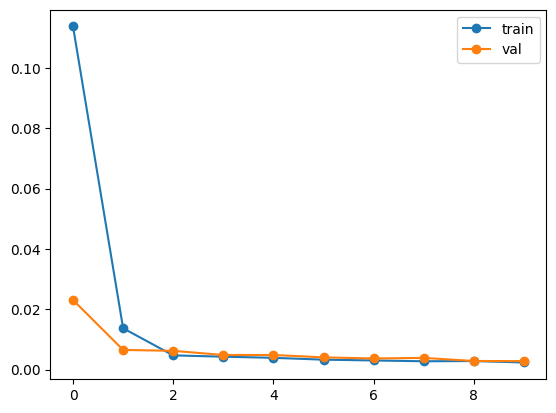

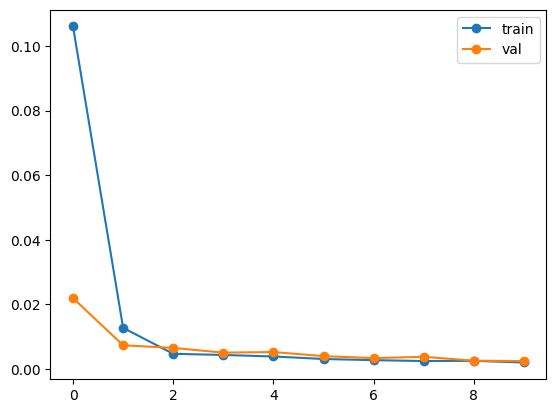

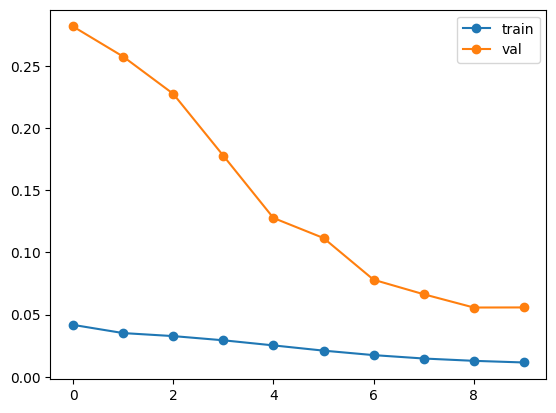

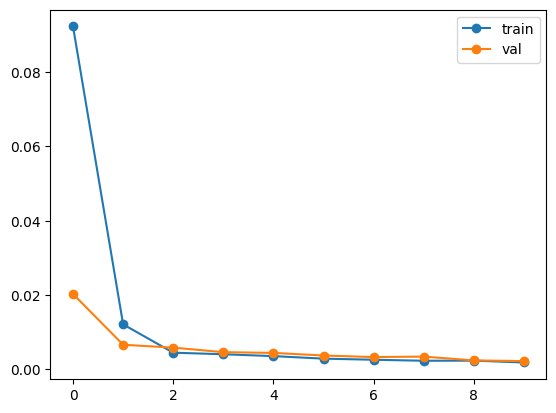

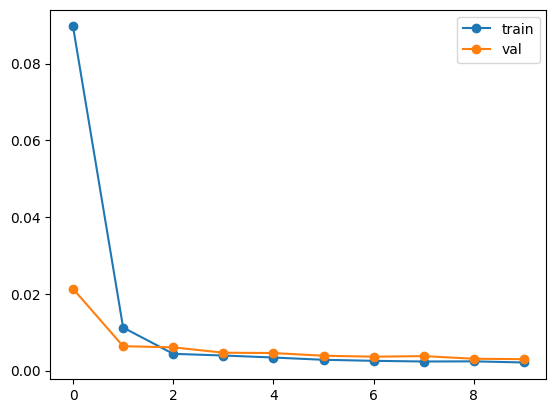

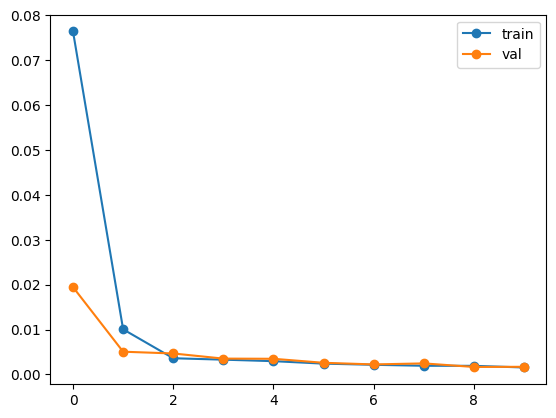

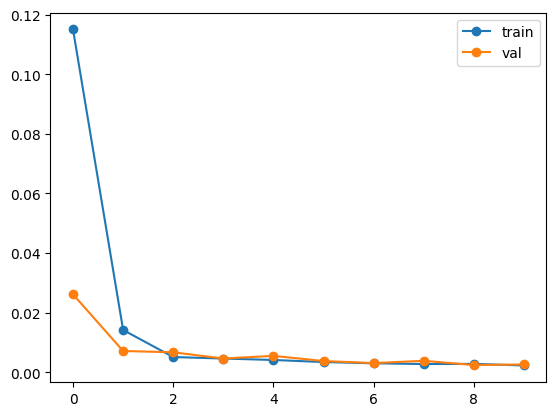

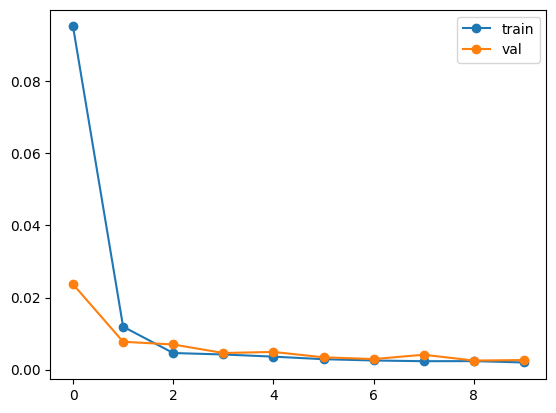


[Epoch    11 of 100] loss_1: 0.002211 val_loss_1: 0.002458 loss_2: 0.001915 val_loss_2: 0.002413 loss_3: 0.010456 val_loss_3: 0.048546 loss_4: 0.001734 val_loss_4: 0.002222 loss_5: 0.002053 val_loss_5: 0.003242 loss_6: 0.001416 val_loss_6: 0.001572 loss_7: 0.002113 val_loss_7: 0.002165 loss_8: 0.001884 val_loss_8: 0.001887
[model_1] Validation loss decreased (0.002825 --> 0.002458).  Saving model ...
[model_2] Validation loss decreased (0.002437 --> 0.002413).  Saving model ...
[model_3] Validation loss decreased (0.055631 --> 0.048546).  Saving model ...
[model_4] Validation loss decreased (0.002241 --> 0.002222).  Saving model ...
[model_5] EarlyStopping counter: 1 out of 5
[model_6] Validation loss decreased (0.001673 --> 0.001572).  Saving model ...
[model_7] Validation loss decreased (0.002367 --> 0.002165).  Saving model ...
[model_8] Validation loss decreased (0.002507 --> 0.001887).  Saving model ...

[Epoch    12 of 100] loss_1: 0.002460 val_loss_1: 0.002305 loss_2: 0.002142 

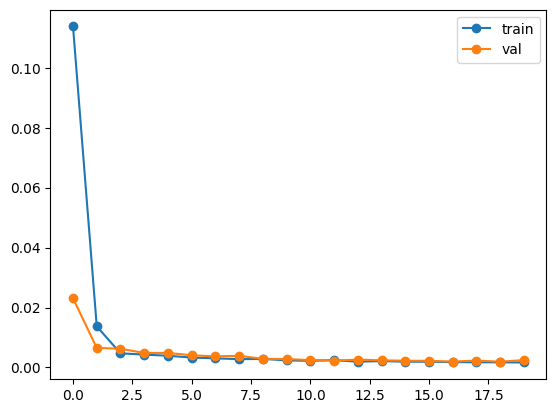

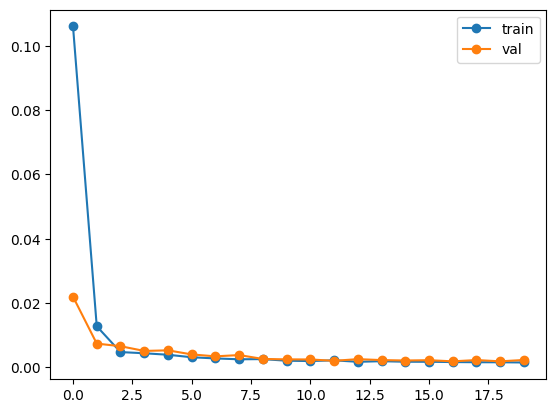

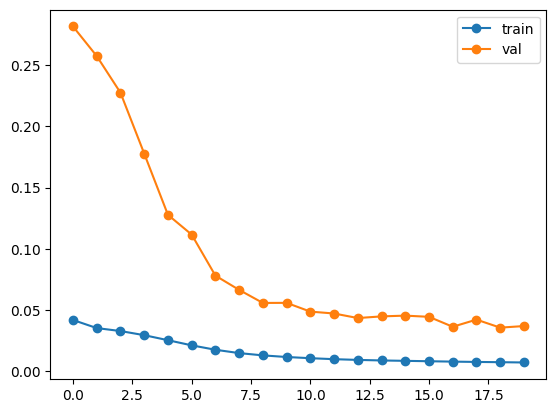

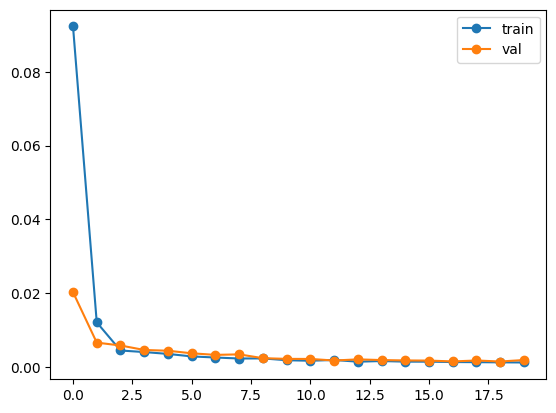

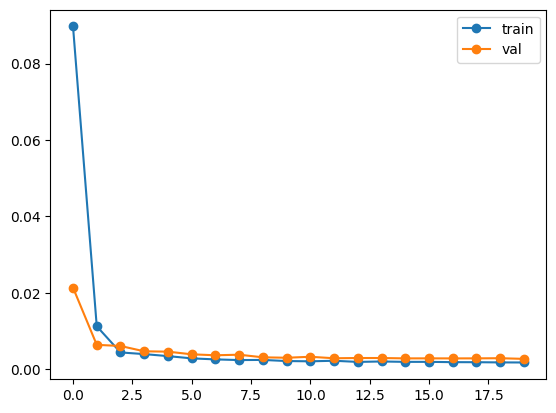

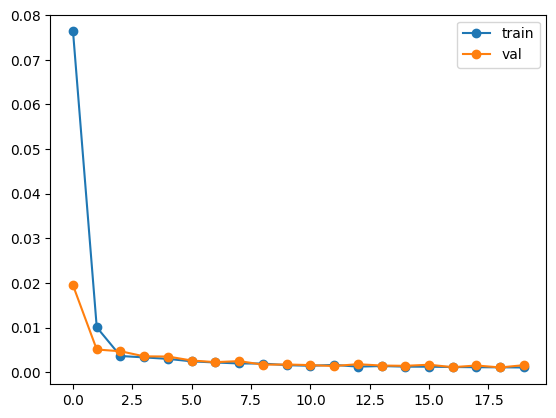

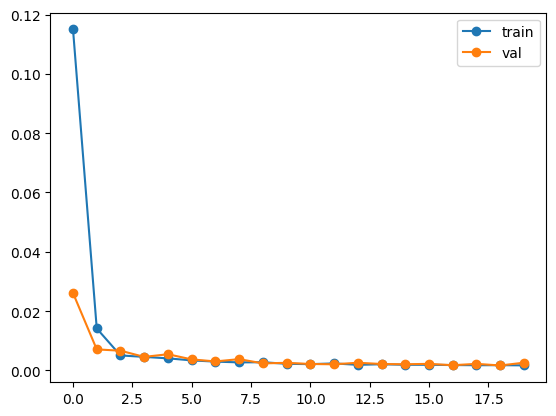

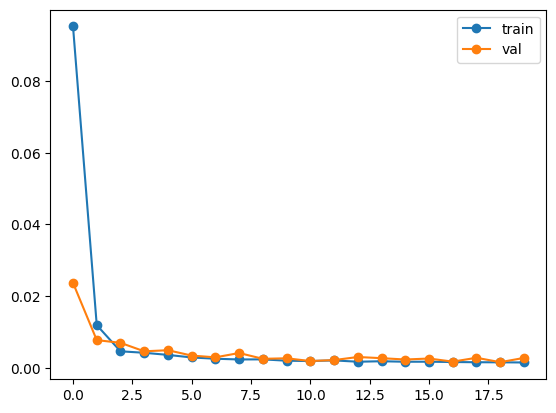


[Epoch    21 of 100] loss_1: 0.001711 val_loss_1: 0.002031 loss_2: 0.001533 val_loss_2: 0.001776 loss_3: 0.006714 val_loss_3: 0.037306 loss_4: 0.001295 val_loss_4: 0.001494 loss_5: 0.001766 val_loss_5: 0.002638 loss_6: 0.001051 val_loss_6: 0.001259 loss_7: 0.001744 val_loss_7: 0.001946 loss_8: 0.001515 val_loss_8: 0.001981
[model_1] EarlyStopping counter: 2 out of 5
[model_2] Validation loss decreased (0.001821 --> 0.001776).  Saving model ...
[model_3] EarlyStopping counter: 2 out of 5
[model_4] Validation loss decreased (0.001526 --> 0.001494).  Saving model ...
[model_5] Validation loss decreased (0.002693 --> 0.002638).  Saving model ...
[model_6] EarlyStopping counter: 2 out of 5
[model_7] EarlyStopping counter: 2 out of 5
[model_8] EarlyStopping counter: 2 out of 5
Early stopping - model_8

[Epoch    22 of 100] loss_1: 0.001611 val_loss_1: 0.002056 loss_2: 0.001412 val_loss_2: 0.001989 loss_3: 0.006520 val_loss_3: 0.035980 loss_4: 0.001204 val_loss_4: 0.001596 loss_5: 0.001709 v

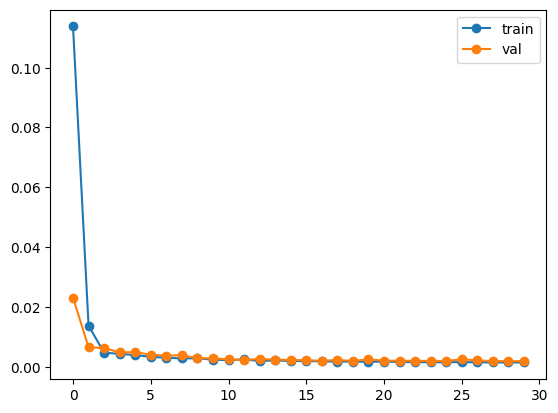

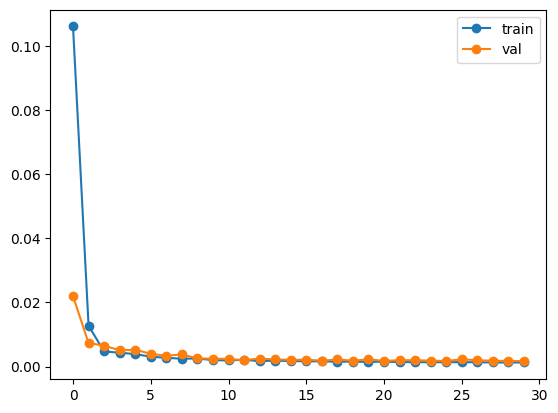

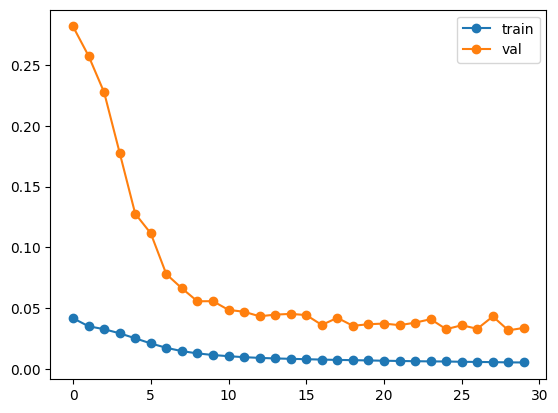

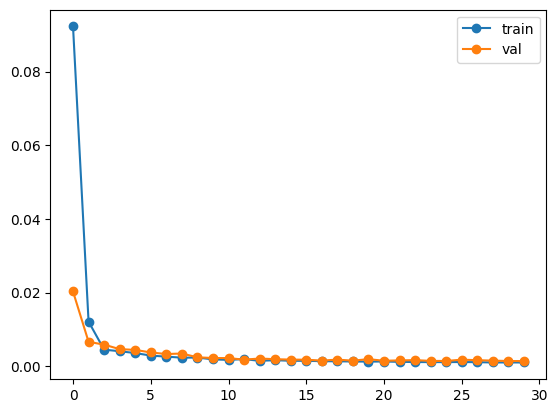

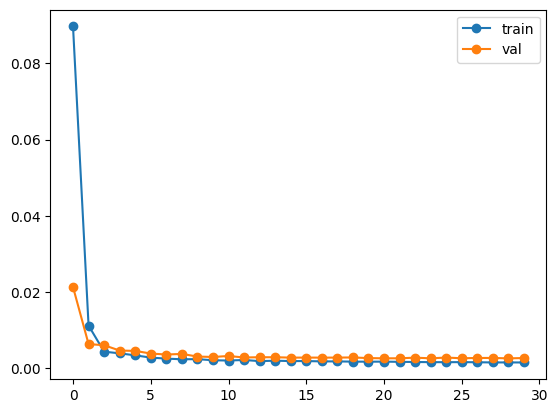

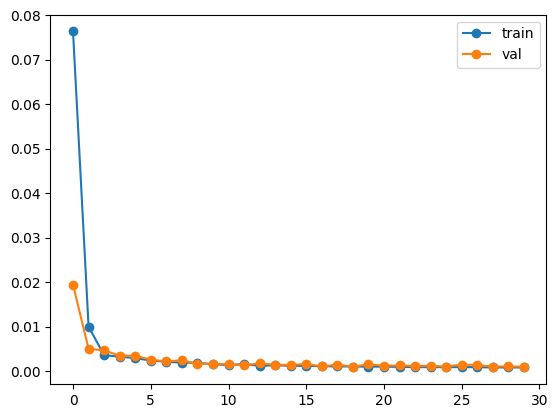

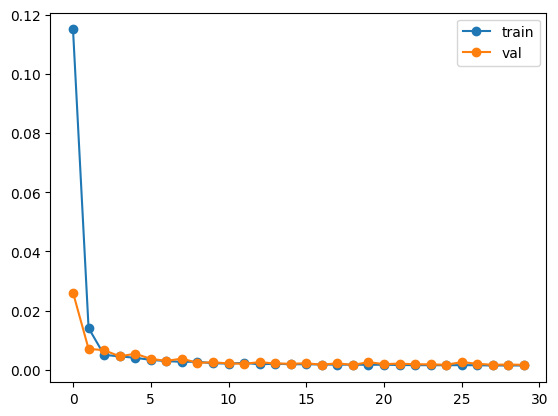

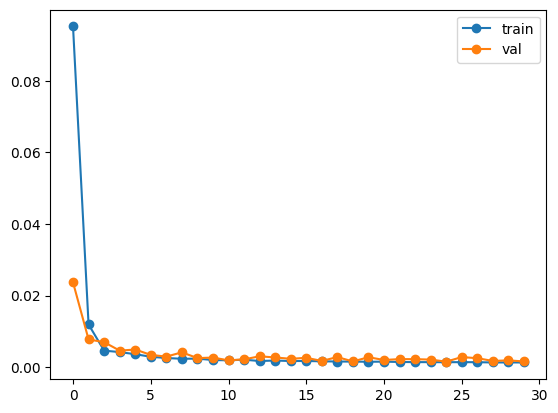


[Epoch    31 of 100] loss_1: 0.001527 val_loss_1: 0.002160 loss_2: 0.001364 val_loss_2: 0.002034 loss_3: 0.005133 val_loss_3: 0.034366 loss_4: 0.001119 val_loss_4: 0.001638 loss_5: 0.001603 val_loss_5: 0.002610 loss_6: 0.000922 val_loss_6: 0.001382 loss_7: 0.001562 val_loss_7: 0.002195 loss_8: 0.001357 val_loss_8: 0.002327
[model_1] EarlyStopping counter: 1 out of 5
[model_2] EarlyStopping counter: 1 out of 5
[model_3] EarlyStopping counter: 2 out of 5
[model_4] EarlyStopping counter: 1 out of 5
[model_5] Validation loss decreased (0.002618 --> 0.002610).  Saving model ...
[model_6] EarlyStopping counter: 1 out of 5
[model_7] EarlyStopping counter: 12 out of 5
[model_8] EarlyStopping counter: 6 out of 5
Early stopping - model_1
Early stopping - model_3
Early stopping - model_6
Early stopping - model_7
Early stopping - model_8

[Epoch    32 of 100] loss_1: 0.001384 val_loss_1: 0.002056 loss_2: 0.001235 val_loss_2: 0.002039 loss_3: 0.005038 val_loss_3: 0.039940 loss_4: 0.000983 val_loss

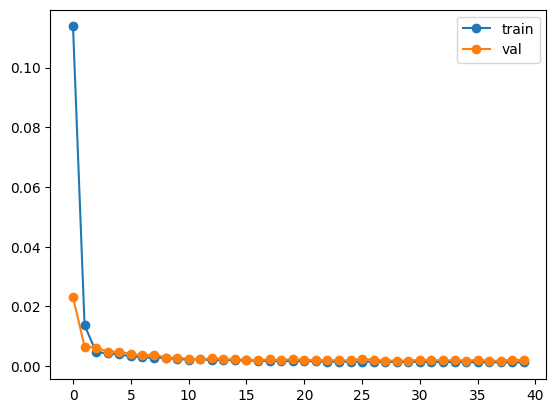

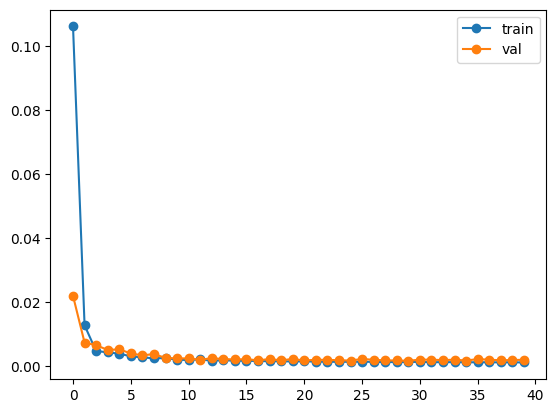

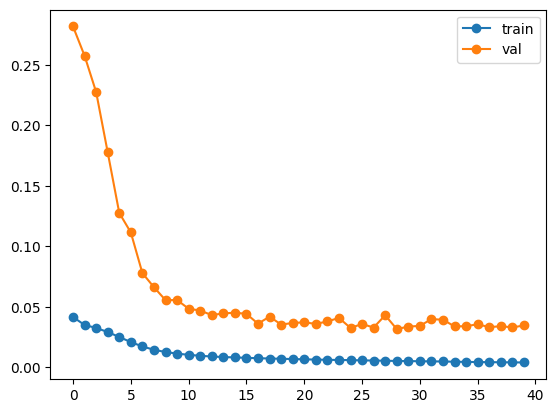

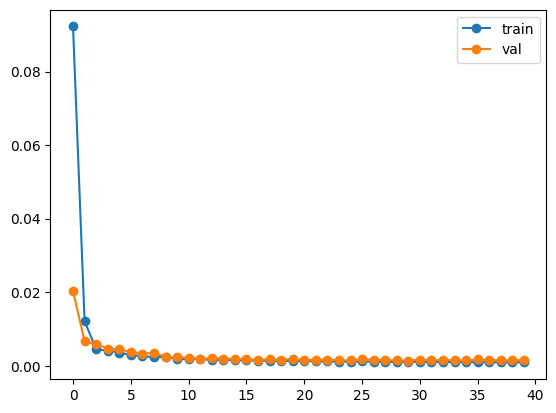

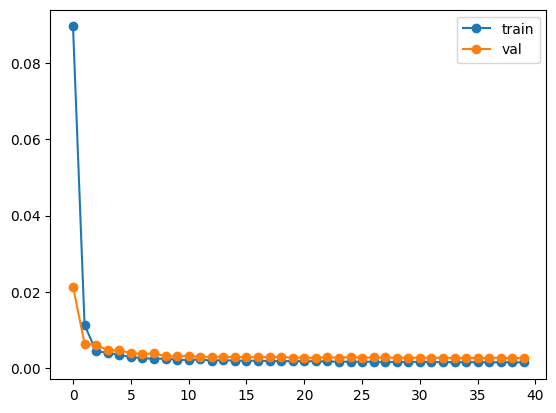

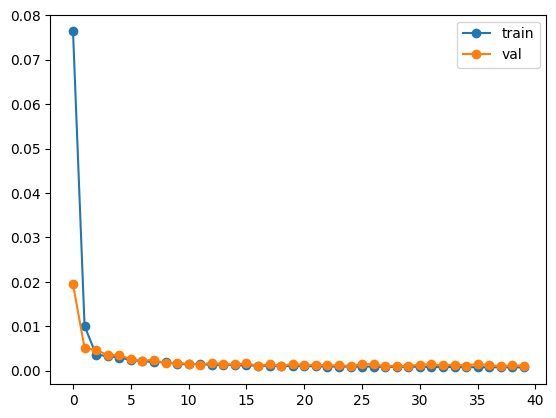

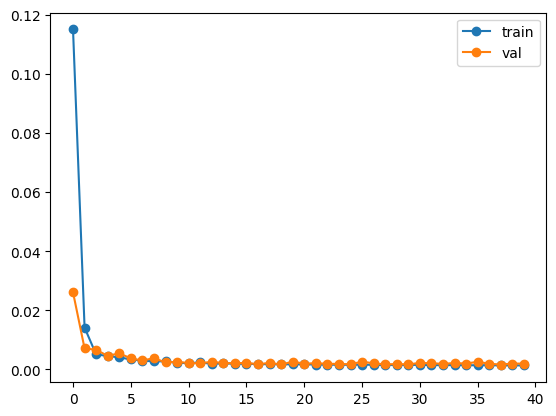

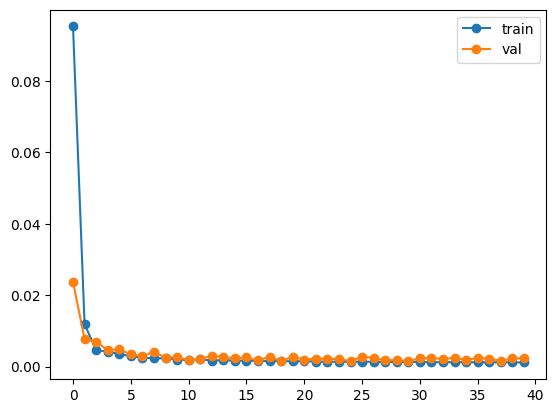


[Epoch    41 of 100] loss_1: 0.001252 val_loss_1: 0.001842 loss_2: 0.001186 val_loss_2: 0.001821 loss_3: 0.004043 val_loss_3: 0.033514 loss_4: 0.000916 val_loss_4: 0.001479 loss_5: 0.001421 val_loss_5: 0.002582 loss_6: 0.000743 val_loss_6: 0.001144 loss_7: 0.001348 val_loss_7: 0.002086 loss_8: 0.001189 val_loss_8: 0.001803
[model_1] EarlyStopping counter: 3 out of 5
[model_2] EarlyStopping counter: 11 out of 5
[model_3] EarlyStopping counter: 12 out of 5
[model_4] EarlyStopping counter: 11 out of 5
[model_5] EarlyStopping counter: 2 out of 5
[model_6] EarlyStopping counter: 3 out of 5
[model_7] EarlyStopping counter: 3 out of 5
[model_8] EarlyStopping counter: 16 out of 5
Early stopping - model_1
Early stopping - model_2
Early stopping - model_3
Early stopping - model_4
Early stopping - model_6
Early stopping - model_7
Early stopping - model_8

[Epoch    42 of 100] loss_1: 0.001237 val_loss_1: 0.002776 loss_2: 0.001173 val_loss_2: 0.002612 loss_3: 0.003955 val_loss_3: 0.034072 loss_4:

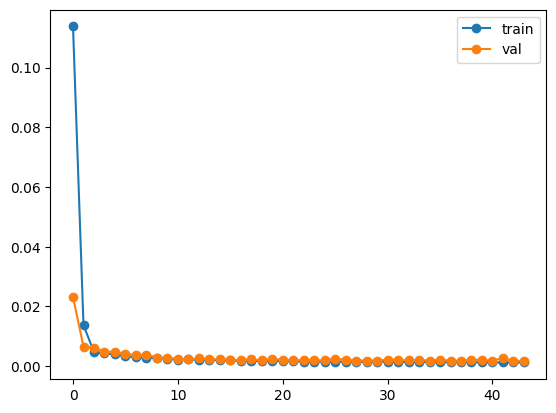

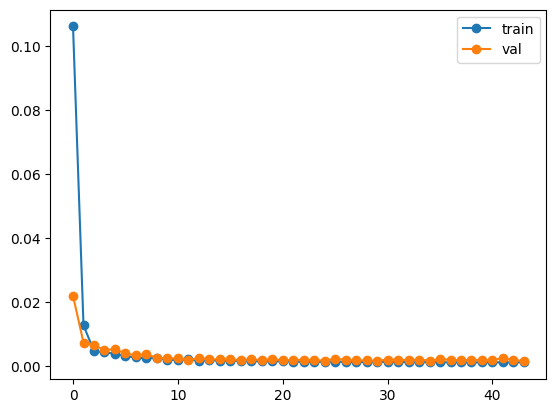

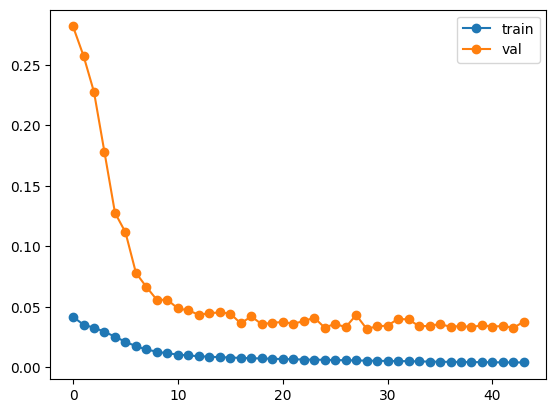

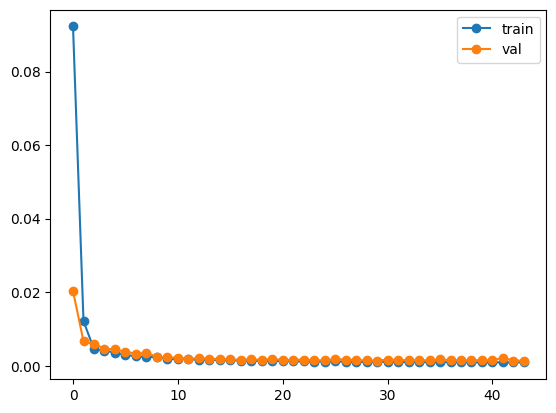

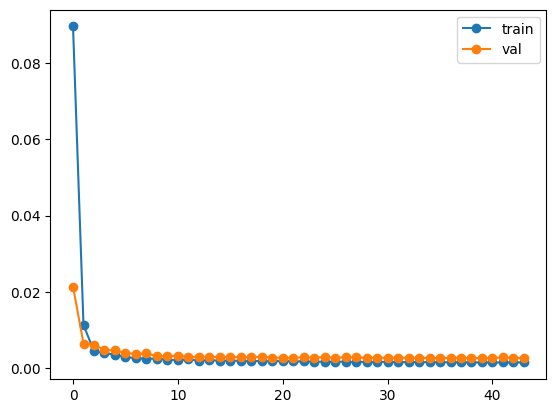

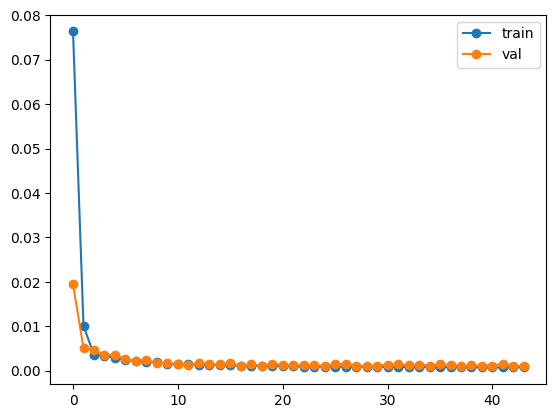

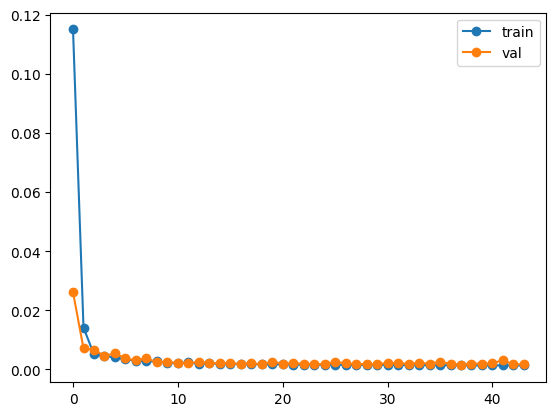

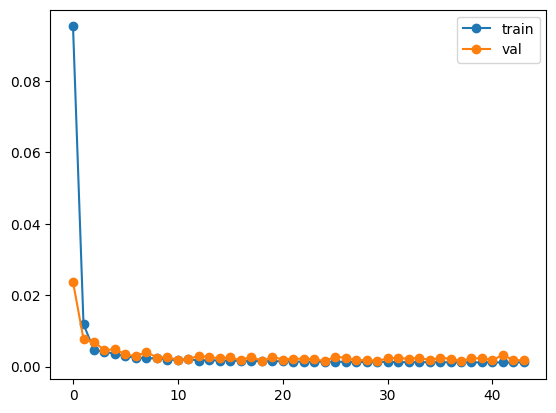


Total time of training: 1.3737516488631567 hours


In [56]:
start_time = time.time()

hist_loss_1 = np.zeros(config_args.epochs)
hist_loss_2 = np.zeros(config_args.epochs)
hist_loss_3 = np.zeros(config_args.epochs)
hist_loss_4 = np.zeros(config_args.epochs)
hist_loss_5 = np.zeros(config_args.epochs)
hist_loss_6 = np.zeros(config_args.epochs)
hist_loss_7 = np.zeros(config_args.epochs)
hist_loss_8 = np.zeros(config_args.epochs)

val_hist_loss_1 = np.zeros(config_args.epochs)
val_hist_loss_2 = np.zeros(config_args.epochs)
val_hist_loss_3 = np.zeros(config_args.epochs)
val_hist_loss_4 = np.zeros(config_args.epochs)
val_hist_loss_5 = np.zeros(config_args.epochs)
val_hist_loss_6 = np.zeros(config_args.epochs)
val_hist_loss_7 = np.zeros(config_args.epochs)
val_hist_loss_8 = np.zeros(config_args.epochs)

val_loss_best_1 = np.inf
val_loss_best_2 = np.inf
val_loss_best_3 = np.inf
val_loss_best_4 = np.inf
val_loss_best_5 = np.inf
val_loss_best_6 = np.inf
val_loss_best_7 = np.inf
val_loss_best_8 = np.inf

count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0

for epoch in range(config_args.epochs):

    # Switching all models in training mode
    model_1.train()
    model_2.train()
    model_3.train()
    model_4.train()
    model_5.train()
    model_6.train()
    model_7.train()
    model_8.train()

    running_loss_1 = 0
    running_loss_2 = 0
    running_loss_3 = 0
    running_loss_4 = 0
    running_loss_5 = 0
    running_loss_6 = 0
    running_loss_7 = 0
    running_loss_8 = 0

    for batch, (categorical_var, continuous_var, target_var) in enumerate(train_dataloader):

        # Setting the gradients to zero
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        optimizer_3.zero_grad()
        optimizer_4.zero_grad()
        optimizer_5.zero_grad()
        optimizer_6.zero_grad()
        optimizer_7.zero_grad()
        optimizer_8.zero_grad()

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)

        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:6]).to(device)
        zone_2_continuous = copy.deepcopy(continuous_var[:, :, 6:12]).to(device)
        zone_3_continuous = copy.deepcopy(continuous_var[:, :, 12:18]).to(device)
        zone_4_continuous = copy.deepcopy(continuous_var[:, :, 18:24]).to(device)
        zone_5_continuous = copy.deepcopy(continuous_var[:, :, 24:30]).to(device)
        zone_6_continuous = copy.deepcopy(continuous_var[:, :, 30:36]).to(device)
        zone_7_continuous = copy.deepcopy(continuous_var[:, :, 36:42]).to(device)
        zone_8_continuous = copy.deepcopy(continuous_var[:, :, 42:48]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])
        zone_2_target = copy.deepcopy(target_var[:, :, 1:2])
        zone_3_target = copy.deepcopy(target_var[:, :, 2:3])
        zone_4_target = copy.deepcopy(target_var[:, :, 3:4])
        zone_5_target = copy.deepcopy(target_var[:, :, 4:5])
        zone_6_target = copy.deepcopy(target_var[:, :, 5:6])
        zone_7_target = copy.deepcopy(target_var[:, :, 6:7])
        zone_8_target = copy.deepcopy(target_var[:, :, 7:8])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)
        out_vae_2, out_transformer_2 = model_2(common_categorical, zone_2_continuous)
        out_vae_3, out_transformer_3 = model_3(common_categorical, zone_3_continuous)
        out_vae_4, out_transformer_4 = model_4(common_categorical, zone_4_continuous)
        out_vae_5, out_transformer_5 = model_5(common_categorical, zone_5_continuous)
        out_vae_6, out_transformer_6 = model_6(common_categorical, zone_6_continuous)
        out_vae_7, out_transformer_7 = model_7(common_categorical, zone_7_continuous)
        out_vae_8, out_transformer_8 = model_8(common_categorical, zone_8_continuous)

        # Calculating the pinball loss
        loss_1 = loss_function(out_transformer_1, zone_1_target.to(device))
        loss_2 = loss_function(out_transformer_2, zone_2_target.to(device))
        loss_3 = loss_function(out_transformer_3, zone_3_target.to(device))
        loss_4 = loss_function(out_transformer_4, zone_4_target.to(device))
        loss_5 = loss_function(out_transformer_5, zone_5_target.to(device))
        loss_6 = loss_function(out_transformer_6, zone_6_target.to(device))
        loss_7 = loss_function(out_transformer_7, zone_7_target.to(device))
        loss_8 = loss_function(out_transformer_8, zone_8_target.to(device))

        # Back-Propagating the loss
        loss_1.backward()
        loss_2.backward()
        loss_3.backward()
        loss_4.backward()
        loss_5.backward()
        loss_6.backward()
        loss_7.backward()
        loss_8.backward()

        # Updating the parameters
        optimizer_1.step()
        optimizer_2.step()
        optimizer_3.step()
        optimizer_4.step()
        optimizer_5.step()
        optimizer_6.step()
        optimizer_7.step()
        optimizer_8.step()

        # Accumulating the running loss
        running_loss_1 += loss_1.item()
        running_loss_2 += loss_2.item()
        running_loss_3 += loss_3.item()
        running_loss_4 += loss_4.item()
        running_loss_5 += loss_5.item()
        running_loss_6 += loss_6.item()
        running_loss_7 += loss_7.item()
        running_loss_8 += loss_8.item()

        train_loss_1 = running_loss_1/len(train_dataloader)
        train_loss_2 = running_loss_2/len(train_dataloader)
        train_loss_3 = running_loss_3/len(train_dataloader)
        train_loss_4 = running_loss_4/len(train_dataloader)
        train_loss_5 = running_loss_5/len(train_dataloader)
        train_loss_6 = running_loss_6/len(train_dataloader)
        train_loss_7 = running_loss_7/len(train_dataloader)
        train_loss_8 = running_loss_8/len(train_dataloader)


        val_loss_1 = compute_val_point_score(model_1, test_dataloader,
                                             loss_function, "zone_1",
                                             device).item()
        val_loss_2 = compute_val_point_score(model_2, test_dataloader,
                                             loss_function, "zone_2",
                                             device).item()
        val_loss_3 = compute_val_point_score(model_3, test_dataloader,
                                             loss_function, "zone_3",
                                             device).item()
        val_loss_4 = compute_val_point_score(model_4, test_dataloader,
                                             loss_function, "zone_4",
                                             device).item()
        val_loss_5 = compute_val_point_score(model_5, test_dataloader,
                                             loss_function, "zone_5",
                                             device).item()
        val_loss_6 = compute_val_point_score(model_6, test_dataloader,
                                             loss_function, "zone_6",
                                             device).item()
        val_loss_7 = compute_val_point_score(model_7, test_dataloader,
                                             loss_function, "zone_7",
                                             device).item()
        val_loss_8 = compute_val_point_score(model_8, test_dataloader,
                                             loss_function, "zone_8",
                                             device).item()

        hist_loss_1[epoch] = train_loss_1
        hist_loss_2[epoch] = train_loss_2
        hist_loss_3[epoch] = train_loss_3
        hist_loss_4[epoch] = train_loss_4
        hist_loss_5[epoch] = train_loss_5
        hist_loss_6[epoch] = train_loss_6
        hist_loss_7[epoch] = train_loss_7
        hist_loss_8[epoch] = train_loss_8

        val_hist_loss_1[epoch] = val_loss_1
        val_hist_loss_2[epoch] = val_loss_2
        val_hist_loss_3[epoch] = val_loss_3
        val_hist_loss_4[epoch] = val_loss_4
        val_hist_loss_5[epoch] = val_loss_5
        val_hist_loss_6[epoch] = val_loss_6
        val_hist_loss_7[epoch] = val_loss_7
        val_hist_loss_8[epoch] = val_loss_8
        
        
    print('\n[Epoch {t:5d} of {epochs}] loss_1: {loss_1:1.6f} val_loss_1: {val_loss_1:1.6f} loss_2: {loss_2:1.6f} val_loss_2: {val_loss_2:1.6f} loss_3: {loss_3:1.6f} val_loss_3: {val_loss_3:1.6f} loss_4: {loss_4:1.6f} val_loss_4: {val_loss_4:1.6f} loss_5: {loss_5:1.6f} val_loss_5: {val_loss_5:1.6f} loss_6: {loss_6:1.6f} val_loss_6: {val_loss_6:1.6f} loss_7: {loss_7:1.6f} val_loss_7: {val_loss_7:1.6f} loss_8: {loss_8:1.6f} val_loss_8: {val_loss_8:1.6f}'.format(t=epoch+1,
                                                                                                                                                                                                          epochs=config_args.epochs,
                                                                                                                                                                                                          loss_1=train_loss_1,
                                                                                                                                                                                                          val_loss_1=val_loss_1,
                                                                                                                                                                                                          loss_2=train_loss_2, 
                                                                                                                                                                                                          val_loss_2=val_loss_2,
                                                                                                                                                                                                          loss_3=train_loss_3,
                                                                                                                                                                                                          val_loss_3=val_loss_3,
                                                                                                                                                                                                          loss_4=train_loss_4,
                                                                                                                                                                                                          val_loss_4=val_loss_4,
                                                                                                                                                                                                          loss_5=train_loss_5,
                                                                                                                                                                                                          val_loss_5=val_loss_5,
                                                                                                                                                                                                          loss_6=train_loss_6,
                                                                                                                                                                                                          val_loss_6=val_loss_6,
                                                                                                                                                                                                          loss_7=train_loss_7,
                                                                                                                                                                                                          val_loss_7=val_loss_7,
                                                                                                                                                                                                          loss_8=train_loss_8,
                                                                                                                                                                                                          val_loss_8=val_loss_8))
    
    # Employing early stopping to avoid overfitting
    early_stopping_1(val_loss_1, model_1)
    early_stopping_2(val_loss_2, model_2)
    early_stopping_3(val_loss_3, model_3)
    early_stopping_4(val_loss_4, model_4)
    early_stopping_5(val_loss_5, model_5)
    early_stopping_6(val_loss_6, model_6)
    early_stopping_7(val_loss_7, model_7)
    early_stopping_8(val_loss_8, model_8)

    if early_stopping_1.early_stop and count_1 < 1:
        print("Early stopping - {}".format(early_stopping_1.model_name))

    if early_stopping_2.early_stop and count_2 < 1:
        print("Early stopping - {}".format(early_stopping_2.model_name))

    if early_stopping_3.early_stop and count_3 < 1:
        print("Early stopping - {}".format(early_stopping_3.model_name))
        
    if early_stopping_4.early_stop and count_4 < 1:
        print("Early stopping - {}".format(early_stopping_4.model_name))

    if early_stopping_5.early_stop and count_5 < 1:
        print("Early stopping - {}".format(early_stopping_5.model_name))

    if early_stopping_6.early_stop and count_6 < 1:
        print("Early stopping - {}".format(early_stopping_6.model_name))
    
    if early_stopping_7.early_stop and count_7 < 1:
        print("Early stopping - {}".format(early_stopping_7.model_name))

    if early_stopping_8.early_stop and count_8 < 1:
        print("Early stopping - {}".format(early_stopping_8.model_name))


    if all((early_stopping_1.early_stop, early_stopping_2.early_stop, early_stopping_3.early_stop, 
            early_stopping_4.early_stop, early_stopping_5.early_stop, early_stopping_6.early_stop,
            early_stopping_7.early_stop, early_stopping_8.early_stop)):
        print("\nAll model stopped early...")
        break
        
            
    if (epoch + 1) % config_args.update_freq == 0:
        print("The plots at epoch {} are:\n".format(epoch+1))
        plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_1, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_2, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_2, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_3, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_3, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_4, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_4, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_5, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_5, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_6, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_6, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_7, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_7, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_8, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_8, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_1, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_2, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_2, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_3, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_3, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_4, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_4, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_5, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_5, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_6, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_6, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_7, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_7, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_8, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_8, 'b'), 'o-', label='val')
plt.legend()
plt.show()

end_time = time.time()

total_time = end_time - start_time
print("\nTotal time of training: {} hours".format(total_time/3600))

### LOADING AND GENERATING RESULTS ON TEST DATALOADER

In [57]:
# Loading the models
best_vae_transformer_1 = load_from_checkpoint(model_1, model_path_1)
best_vae_transformer_2 = load_from_checkpoint(model_2, model_path_2)
best_vae_transformer_3 = load_from_checkpoint(model_3, model_path_3)
best_vae_transformer_4 = load_from_checkpoint(model_4, model_path_4)
best_vae_transformer_5 = load_from_checkpoint(model_5, model_path_5)
best_vae_transformer_6 = load_from_checkpoint(model_6, model_path_6)
best_vae_transformer_7 = load_from_checkpoint(model_7, model_path_7)
best_vae_transformer_8 = load_from_checkpoint(model_8, model_path_8)


In [58]:
point_pred_1 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_2 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_3 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_4 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_5 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_6 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_7 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_8 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
idx_pred_1 = 0
idx_pred_2 = 0
idx_pred_3 = 0
idx_pred_4 = 0
idx_pred_5 = 0
idx_pred_6 = 0
idx_pred_7 = 0
idx_pred_8 = 0

# Switching all models to eval mode
model_1.eval()
model_2.eval()
model_3.eval()
model_4.eval()
model_5.eval()
model_6.eval()
model_7.eval()
model_8.eval()

with torch.no_grad():
    for (categorical_var, continuous_var, target_var) in tqdm(test_dataloader, total=len(test_dataloader)):

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)

        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:6]).to(device)
        zone_2_continuous = copy.deepcopy(continuous_var[:, :, 6:12]).to(device)
        zone_3_continuous = copy.deepcopy(continuous_var[:, :, 12:18]).to(device)
        zone_4_continuous = copy.deepcopy(continuous_var[:, :, 18:24]).to(device)
        zone_5_continuous = copy.deepcopy(continuous_var[:, :, 24:30]).to(device)
        zone_6_continuous = copy.deepcopy(continuous_var[:, :, 30:36]).to(device)
        zone_7_continuous = copy.deepcopy(continuous_var[:, :, 36:42]).to(device)
        zone_8_continuous = copy.deepcopy(continuous_var[:, :, 42:48]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])
        zone_2_target = copy.deepcopy(target_var[:, :, 1:2])
        zone_3_target = copy.deepcopy(target_var[:, :, 2:3])
        zone_4_target = copy.deepcopy(target_var[:, :, 3:4])
        zone_5_target = copy.deepcopy(target_var[:, :, 4:5])
        zone_6_target = copy.deepcopy(target_var[:, :, 5:6])
        zone_7_target = copy.deepcopy(target_var[:, :, 6:7])
        zone_8_target = copy.deepcopy(target_var[:, :, 7:8])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)
        out_vae_2, out_transformer_2 = model_2(common_categorical, zone_2_continuous)
        out_vae_3, out_transformer_3 = model_3(common_categorical, zone_3_continuous)
        out_vae_4, out_transformer_4 = model_4(common_categorical, zone_4_continuous)
        out_vae_5, out_transformer_5 = model_5(common_categorical, zone_5_continuous)
        out_vae_6, out_transformer_6 = model_6(common_categorical, zone_6_continuous)
        out_vae_7, out_transformer_7 = model_7(common_categorical, zone_7_continuous)
        out_vae_8, out_transformer_8 = model_8(common_categorical, zone_8_continuous)

        # Concatenating the predictions
        point_pred_1[idx_pred_1:idx_pred_1+zone_1_continuous.shape[0]] = out_transformer_1.cpu().numpy()

        point_pred_2[idx_pred_2:idx_pred_2+zone_2_continuous.shape[0]] = out_transformer_2.cpu().numpy()

        point_pred_3[idx_pred_3:idx_pred_3+zone_3_continuous.shape[0]] = out_transformer_3.cpu().numpy()

        point_pred_4[idx_pred_4:idx_pred_4+zone_4_continuous.shape[0]] = out_transformer_4.cpu().numpy()

        point_pred_5[idx_pred_5:idx_pred_5+zone_5_continuous.shape[0]] = out_transformer_5.cpu().numpy()

        point_pred_6[idx_pred_6:idx_pred_6+zone_6_continuous.shape[0]] = out_transformer_6.cpu().numpy()

        point_pred_7[idx_pred_7:idx_pred_7+zone_7_continuous.shape[0]] = out_transformer_7.cpu().numpy()

        point_pred_8[idx_pred_8:idx_pred_8+zone_8_continuous.shape[0]] = out_transformer_8.cpu().numpy()

        idx_pred_1 += zone_1_continuous.shape[0]
        idx_pred_2 += zone_2_continuous.shape[0]
        idx_pred_3 += zone_3_continuous.shape[0]
        idx_pred_4 += zone_4_continuous.shape[0]
        idx_pred_5 += zone_5_continuous.shape[0]
        idx_pred_6 += zone_6_continuous.shape[0]
        idx_pred_7 += zone_7_continuous.shape[0]
        idx_pred_8 += zone_8_continuous.shape[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


#### FORMATTING PREDICTED AND TRUE DATA FOR GENERATING RESULTS

In [59]:
# Reshaping the predicted quantiles
point_pred_arr_1 = point_pred_1.reshape(-1, model_args.d_output)
point_pred_arr_2 = point_pred_2.reshape(-1, model_args.d_output)
point_pred_arr_3 = point_pred_3.reshape(-1, model_args.d_output)
point_pred_arr_4 = point_pred_4.reshape(-1, model_args.d_output)
point_pred_arr_5 = point_pred_5.reshape(-1, model_args.d_output)
point_pred_arr_6 = point_pred_6.reshape(-1, model_args.d_output)
point_pred_arr_7 = point_pred_7.reshape(-1, model_args.d_output)
point_pred_arr_8 = point_pred_8.reshape(-1, model_args.d_output)

point_pred_arr_1.shape

(8760, 1)

In [60]:
point_pred_1_inv = point_pred_arr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]
point_pred_2_inv = point_pred_arr_2 * (mm_scaler_Y.data_max_[1] - mm_scaler_Y.data_min_[1]) + mm_scaler_Y.data_min_[1]
point_pred_3_inv = point_pred_arr_3 * (mm_scaler_Y.data_max_[2] - mm_scaler_Y.data_min_[2]) + mm_scaler_Y.data_min_[2]
point_pred_4_inv = point_pred_arr_4 * (mm_scaler_Y.data_max_[3] - mm_scaler_Y.data_min_[3]) + mm_scaler_Y.data_min_[3]
point_pred_5_inv = point_pred_arr_5 * (mm_scaler_Y.data_max_[4] - mm_scaler_Y.data_min_[4]) + mm_scaler_Y.data_min_[4]
point_pred_6_inv = point_pred_arr_6 * (mm_scaler_Y.data_max_[5] - mm_scaler_Y.data_min_[5]) + mm_scaler_Y.data_min_[5]
point_pred_7_inv = point_pred_arr_7 * (mm_scaler_Y.data_max_[6] - mm_scaler_Y.data_min_[6]) + mm_scaler_Y.data_min_[6]
point_pred_8_inv = point_pred_arr_8 * (mm_scaler_Y.data_max_[7] - mm_scaler_Y.data_min_[7]) + mm_scaler_Y.data_min_[7]

point_pred_1_inv.shape

(8760, 1)

In [61]:
# Reshaping the true data
Y_test_1 = target_samples_testing[:, :, 0:1]
Y_test_2 = target_samples_testing[:, :, 1:2]
Y_test_3 = target_samples_testing[:, :, 2:3]
Y_test_4 = target_samples_testing[:, :, 3:4]
Y_test_5 = target_samples_testing[:, :, 4:5]
Y_test_6 = target_samples_testing[:, :, 5:6]
Y_test_7 = target_samples_testing[:, :, 6:7]
Y_test_8 = target_samples_testing[:, :, 7:8]

yArr_1 = Y_test_1.reshape(Y_test_1.shape[0] * Y_test_1.shape[1], Y_test_1.shape[2]).numpy()
yArr_2 = Y_test_2.reshape(Y_test_2.shape[0] * Y_test_2.shape[1], Y_test_2.shape[2]).numpy()
yArr_3 = Y_test_3.reshape(Y_test_3.shape[0] * Y_test_3.shape[1], Y_test_3.shape[2]).numpy()
yArr_4 = Y_test_4.reshape(Y_test_4.shape[0] * Y_test_4.shape[1], Y_test_4.shape[2]).numpy()
yArr_5 = Y_test_5.reshape(Y_test_5.shape[0] * Y_test_5.shape[1], Y_test_5.shape[2]).numpy()
yArr_6 = Y_test_6.reshape(Y_test_6.shape[0] * Y_test_6.shape[1], Y_test_6.shape[2]).numpy()
yArr_7 = Y_test_7.reshape(Y_test_7.shape[0] * Y_test_7.shape[1], Y_test_7.shape[2]).numpy()
yArr_8 = Y_test_8.reshape(Y_test_8.shape[0] * Y_test_8.shape[1], Y_test_8.shape[2]).numpy()

yArr_1.shape

(8760, 1)

In [62]:
yArr_1_inv = yArr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]
yArr_2_inv = yArr_2 * (mm_scaler_Y.data_max_[1] - mm_scaler_Y.data_min_[1]) + mm_scaler_Y.data_min_[1]
yArr_3_inv = yArr_3 * (mm_scaler_Y.data_max_[2] - mm_scaler_Y.data_min_[2]) + mm_scaler_Y.data_min_[2]
yArr_4_inv = yArr_4 * (mm_scaler_Y.data_max_[3] - mm_scaler_Y.data_min_[3]) + mm_scaler_Y.data_min_[3]
yArr_5_inv = yArr_5 * (mm_scaler_Y.data_max_[4] - mm_scaler_Y.data_min_[4]) + mm_scaler_Y.data_min_[4]
yArr_6_inv = yArr_6 * (mm_scaler_Y.data_max_[5] - mm_scaler_Y.data_min_[5]) + mm_scaler_Y.data_min_[5]
yArr_7_inv = yArr_7 * (mm_scaler_Y.data_max_[6] - mm_scaler_Y.data_min_[6]) + mm_scaler_Y.data_min_[6]
yArr_8_inv = yArr_8 * (mm_scaler_Y.data_max_[7] - mm_scaler_Y.data_min_[7]) + mm_scaler_Y.data_min_[7]

#### CALCULATING THE MAPE ON TEST DATA

In [63]:
compare_df_1 = pd.DataFrame(data= {"Values": yArr_1_inv[:, 0], "Predictions": point_pred_1_inv[:, 0]})
compare_df_1

,Values,Predictions
0,9783.594727,9839.363301
1,9726.062500,9775.932306
2,9654.373047,9725.304320
3,9631.735352,9674.825400
4,9698.888672,9898.232953
...,...,...
8755,11109.257812,11532.091234
8756,10846.500000,11511.353413
8757,10592.539062,11270.211459
8758,10304.625000,10806.272948


In [64]:
compare_df_2 = pd.DataFrame(data= {"Values": yArr_2_inv[:, 0], "Predictions": point_pred_2_inv[:, 0]})
compare_df_2

,Values,Predictions
0,1264.194092,1234.835606
1,1270.494263,1247.266466
2,1269.504150,1238.969762
3,1243.168457,1252.021487
4,1309.572876,1275.514675
...,...,...
8755,1417.306763,1577.601121
8756,1411.761108,1572.874740
8757,1403.990601,1586.336960
8758,1387.051514,1499.115103


In [65]:
compare_df_3 = pd.DataFrame(data= {"Values": yArr_3_inv[:, 0], "Predictions": point_pred_3_inv[:, 0]})
compare_df_3

,Values,Predictions
0,3164.720703,3165.784860
1,3178.950684,3039.538270
2,3200.881104,2988.760226
3,3221.962891,3007.880348
4,3240.634766,3064.136797
...,...,...
8755,3637.456543,3261.950127
8756,3639.019287,3272.860771
8757,3639.463867,3281.291697
8758,3630.184814,3281.831669


In [66]:
compare_df_4 = pd.DataFrame(data= {"Values": yArr_4_inv[:, 0], "Predictions": point_pred_4_inv[:, 0]})
compare_df_4

,Values,Predictions
0,11697.765625,11874.629393
1,11787.935547,11512.922890
2,11861.628906,11326.720131
3,11989.105469,11232.791076
4,12219.106445,11712.942201
...,...,...
8755,13164.661133,14637.521407
8756,12928.912109,14526.841109
8757,12716.274414,13992.379269
8758,12413.089844,13303.664409


In [67]:
compare_df_5 = pd.DataFrame(data= {"Values": yArr_5_inv[:, 0], "Predictions": point_pred_5_inv[:, 0]})
compare_df_5

,Values,Predictions
0,827.759399,874.448720
1,830.256226,873.798232
2,831.505493,869.606015
3,839.689819,862.082986
4,848.672119,882.194287
...,...,...
8755,825.761780,903.601567
8756,822.190552,901.602281
8757,819.393982,896.762001
8758,804.714722,858.367517


In [68]:
compare_df_6 = pd.DataFrame(data= {"Values": yArr_6_inv[:, 0], "Predictions": point_pred_6_inv[:, 0]})
compare_df_6

,Values,Predictions
0,5993.974609,6341.887808
1,6029.773926,6254.460984
2,6043.348633,6128.958574
3,6086.408203,6159.659114
4,6180.939941,6319.958807
...,...,...
8755,6453.697266,6730.276988
8756,6175.763184,6661.882465
8757,5968.287598,6518.799164
8758,5769.745117,6269.031416


In [69]:
compare_df_7 = pd.DataFrame(data= {"Values": yArr_7_inv[:, 0], "Predictions": point_pred_7_inv[:, 0]})
compare_df_7

,Values,Predictions
0,3066.891113,3089.671691
1,3140.383301,3040.556460
2,3137.721436,2993.056553
3,3105.497070,3022.077611
4,3078.256348,3167.999056
...,...,...
8755,3181.359863,3269.713191
8756,3044.648926,3213.701759
8757,2930.563477,3099.470802
8758,2829.531982,2954.039370


In [70]:
compare_df_8 = pd.DataFrame(data= {"Values": yArr_8_inv[:, 0], "Predictions": point_pred_8_inv[:, 0]})
compare_df_8

,Values,Predictions
0,1282.542969,1258.939712
1,1295.132812,1263.246858
2,1301.225098,1261.793225
3,1305.976074,1283.372051
4,1319.140503,1320.885950
...,...,...
8755,1290.258301,1368.585082
8756,1276.748535,1386.938653
8757,1260.087891,1353.728509
8758,1238.412231,1310.888324


In [71]:
print("Saving the best trained models.")

# Saving the models
torch.save(best_vae_transformer_1, f"vae_transformer_models/L4_vae_transformer_1.pth")
torch.save(best_vae_transformer_2, f"vae_transformer_models/L4_vae_transformer_2.pth")
torch.save(best_vae_transformer_3, f"vae_transformer_models/L4_vae_transformer_3.pth")
torch.save(best_vae_transformer_4, f"vae_transformer_models/L4_vae_transformer_4.pth")
torch.save(best_vae_transformer_5, f"vae_transformer_models/L4_vae_transformer_5.pth")
torch.save(best_vae_transformer_6, f"vae_transformer_models/L4_vae_transformer_6.pth")
torch.save(best_vae_transformer_7, f"vae_transformer_models/L4_vae_transformer_7.pth")
torch.save(best_vae_transformer_8, f"vae_transformer_models/L4_vae_transformer_8.pth")

print("Saved !")

Saving the best trained models.
Saved !


#### EXAMINING THE RESULTS

In [72]:
mape_max_val = mm_scaler_Y.data_max_.max()

New MAPE:  1.4806983796184703
Old MAPE:  1.8459340437275127


<Axes: >

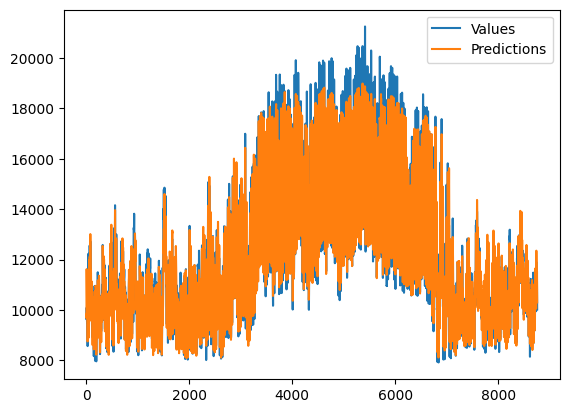

In [73]:
result_mape_1 = new_mape(compare_df_1["Values"], compare_df_1["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_1)
print("Old MAPE: ", mape(compare_df_1["Values"], compare_df_1["Predictions"]))
compare_df_1.plot()

New MAPE:  0.2108607515808123
Old MAPE:  2.1877902169141246


<Axes: >

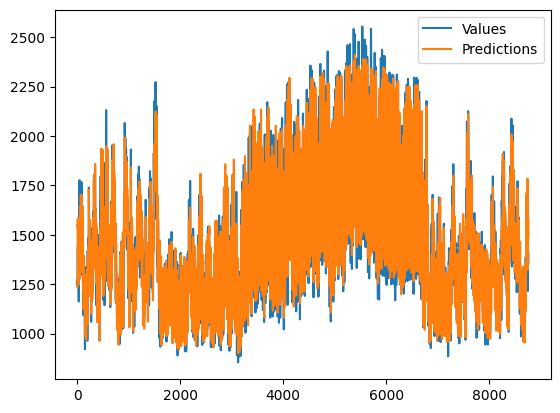

In [74]:
result_mape_2 = new_mape(compare_df_2["Values"], compare_df_2["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_2)
print("Old MAPE: ", mape(compare_df_2["Values"], compare_df_2["Predictions"]))
compare_df_2.plot()

New MAPE:  1.0743094071851755
Old MAPE:  6.60894609926436


<Axes: >

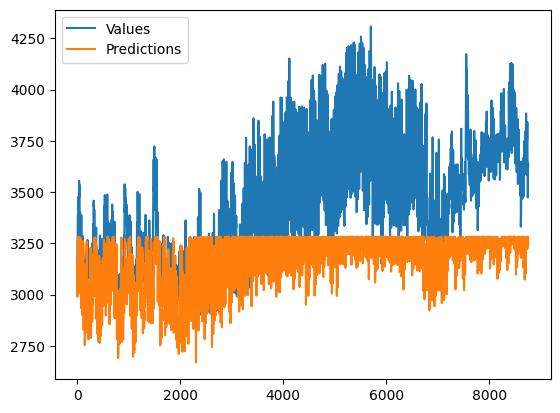

In [75]:
result_mape_3 = new_mape(compare_df_3["Values"], compare_df_3["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_3)
print("Old MAPE: ", mape(compare_df_3["Values"], compare_df_3["Predictions"]))
compare_df_3.plot()

New MAPE:  1.9340619736444606
Old MAPE:  2.010339313743174


<Axes: >

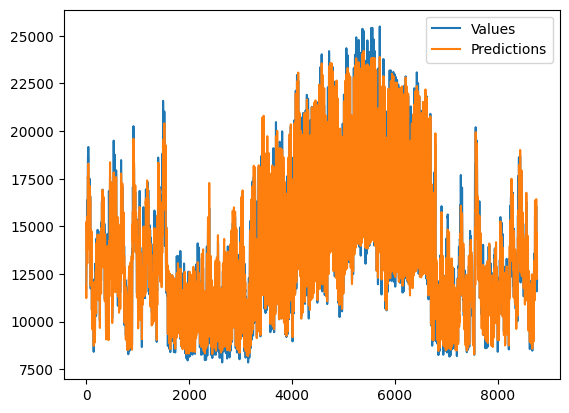

In [76]:
result_mape_4 = new_mape(compare_df_4["Values"], compare_df_4["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_4)
print("Old MAPE: ", mape(compare_df_4["Values"], compare_df_4["Predictions"]))
compare_df_4.plot()

New MAPE:  0.13916899964410398
Old MAPE:  2.49800062976608


<Axes: >

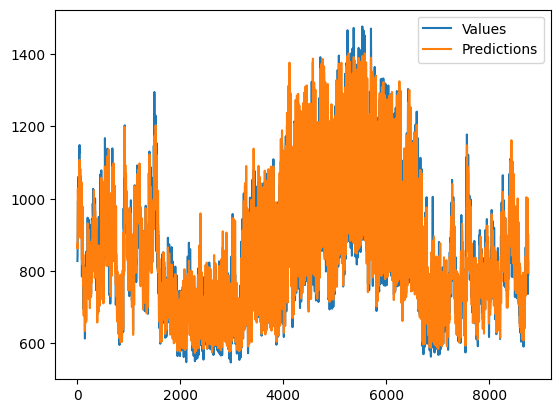

In [77]:
result_mape_5 = new_mape(compare_df_5["Values"], compare_df_5["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_5)
print("Old MAPE: ", mape(compare_df_5["Values"], compare_df_5["Predictions"]))
compare_df_5.plot()

New MAPE:  0.9107640477284064
Old MAPE:  1.887745412992383


<Axes: >

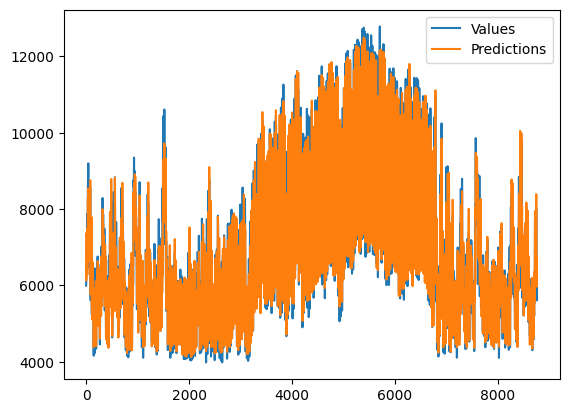

In [78]:
result_mape_6 = new_mape(compare_df_6["Values"], compare_df_6["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_6)
print("Old MAPE: ", mape(compare_df_6["Values"], compare_df_6["Predictions"]))
compare_df_6.plot()

New MAPE:  0.4859239376917821
Old MAPE:  2.1319909839856646


<Axes: >

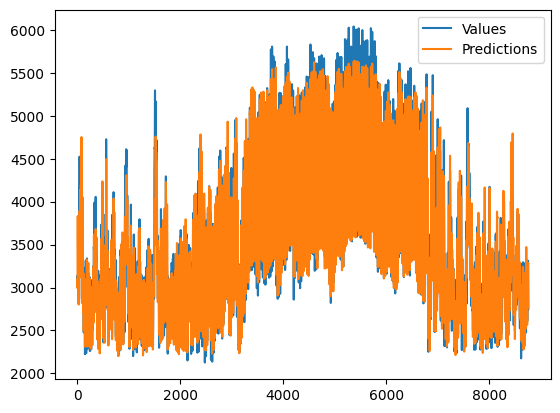

In [79]:
result_mape_7 = new_mape(compare_df_7["Values"], compare_df_7["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_7)
print("Old MAPE: ", mape(compare_df_7["Values"], compare_df_7["Predictions"]))
compare_df_7.plot()

New MAPE:  0.15002120068810415
Old MAPE:  1.8775146424276559


<Axes: >

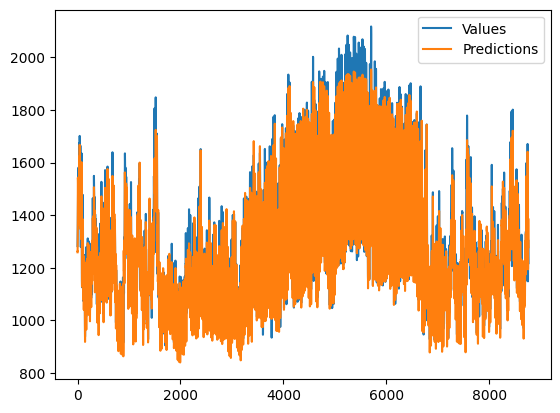

In [80]:
result_mape_8 = new_mape(compare_df_8["Values"], compare_df_8["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_8)
print("Old MAPE: ", mape(compare_df_8["Values"], compare_df_8["Predictions"]))
compare_df_8.plot()

In [81]:
resultsDf = pd.DataFrame()
resultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
resultsDf["mape"] = [
result_mape_1, result_mape_2, result_mape_3,
result_mape_4, result_mape_5, result_mape_6,
result_mape_7, result_mape_8,
]

resultsDf.to_csv(os.path.join("lag_24_results", "v2_new_" + dataset + ".csv"), index=False)
print("Results saved !")

Results saved !


In [82]:
resultsDf

,zone,mape
0,COAST,1.480698
1,EAST,0.210861
2,FWEST,1.074309
3,NCENT,1.934062
4,NORTH,0.139169
5,SCENT,0.910764
6,SOUTH,0.485924
7,ZWEST,0.150021


In [83]:
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [84]:
oldResultsDf = pd.DataFrame()
oldResultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
oldResultsDf["mape"] = [
    mape(compare_df_1["Values"], compare_df_1["Predictions"]), 
    mape(compare_df_2["Values"], compare_df_2["Predictions"]), 
    mape(compare_df_3["Values"], compare_df_3["Predictions"]),
    mape(compare_df_4["Values"], compare_df_4["Predictions"]),
    mape(compare_df_5["Values"], compare_df_5["Predictions"]),
    mape(compare_df_6["Values"], compare_df_6["Predictions"]),
    mape(compare_df_7["Values"], compare_df_7["Predictions"]),
    mape(compare_df_8["Values"], compare_df_8["Predictions"]),
]

oldResultsDf.to_csv(os.path.join("lag_24_results", "v2_old_" + dataset + ".csv"), index=False)
print("Results saved !")

oldResultsDf

Results saved !


,zone,mape
0,COAST,1.845934
1,EAST,2.187790
2,FWEST,6.608946
3,NCENT,2.010339
4,NORTH,2.498001
5,SCENT,1.887745
6,SOUTH,2.131991
7,ZWEST,1.877515
